# Obligatorio: Curso Análisis Predictivo de Series Temporales

## Posgrado de Analítica de Big Data

## Universidad ORT Uruguay

### Curso 2021

**Integrantes:** 

 * Mauricio Martinez (134283)
 * Augusto Romero (253261)
 * Enrique Peirano (252190)

## Serie de consumo de Slots de una plataforma analítica de datos (Big Query)

Para este trabajo usaremos la serie temporal del uso de slots de un proyecto de Big Query. Big Query es un motor analítico de tipo SaaS que forma parte de las herramientas de Google Cloud Platform. Se trata de un servicio serverless que permite a las organizaciones administrarlo y controlar sus costos en base a distintos modelos de pricing.
El modelo que nos interesa analizar es el de los llamados "slots". En Big Query un "slot" es una unidad de procesamiento (similar a un cpu virtual). Las consultas analíticas que se realizan sobre la plataforma son procesadas por slots y éstos son asignados por la plataforma de acuerdo a la demanda, la disponibilidad y la complejidad de las consultas.
Nuestra serie de datos representa el uso de slots por intervalo de tiempo (medido en milisegundos de uso). Ejemplo: si en un intervalo de un segundo se registra un uso de 1500ms de slots podemos decir que se usaron 1.5 slots. Si bien esta es la unidad de medida original, para este trabajo decidimos realizar una modificación en el muestreo (los intervalos son de 5 minutos) y la unidad de medida es la cantidad de slots utilizados.


 * Tomamos el mes de mayo 2021
 
 * Los Slots se pueden comprar cada 5 minutos, por lo que decidimos trabajar con esa unidad de tiempo
 
 * t = 21 días hábiles * 288 (1 dia) = 6048 total 
 
 * Dividimos la serie entre Train y Test


### Paquetes:

In [2]:
#install.packages('Metrics')
library('astsa')
library(forecast)
library('Metrics')

options(repr.plot.width=14, repr.plot.height=6)


Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas



Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy




In [3]:
setwd('./')
ts_df <- read.csv("./data/proyectos_analiticos_20210501-20210531_no_weekends_resampled.csv")

Para convertir la unidad de medida a cantidad de slots por intervalo, dividimos los valores de la serie entre 300000 (cantidad de milisegundos cada 5 minutos)

In [4]:
ts_df <- ts_df[,2]
ts_df = ts_df/300000 # paso la unidad a slots
ts_df = ts(ts_df, start=0, frequency=1)

In [6]:
length(ts_df)

[1] 6048

### La Serie

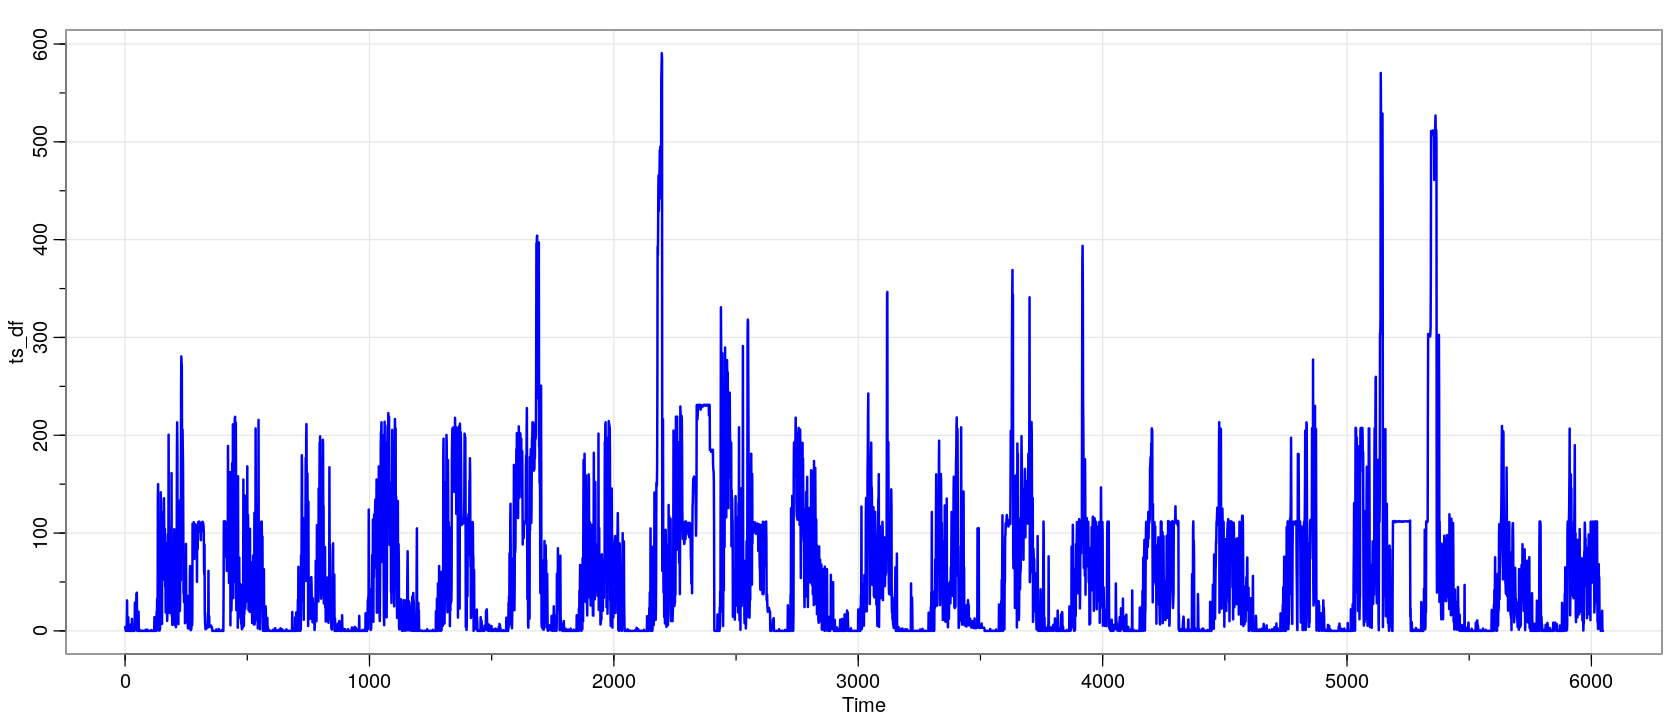

In [7]:
tsplot(ts_df, col=4, lwd=2)

A simple vista se observan los períodos de uso de la plataforma, con un comportamiento relativamente similar (con período de 288 observaciones).

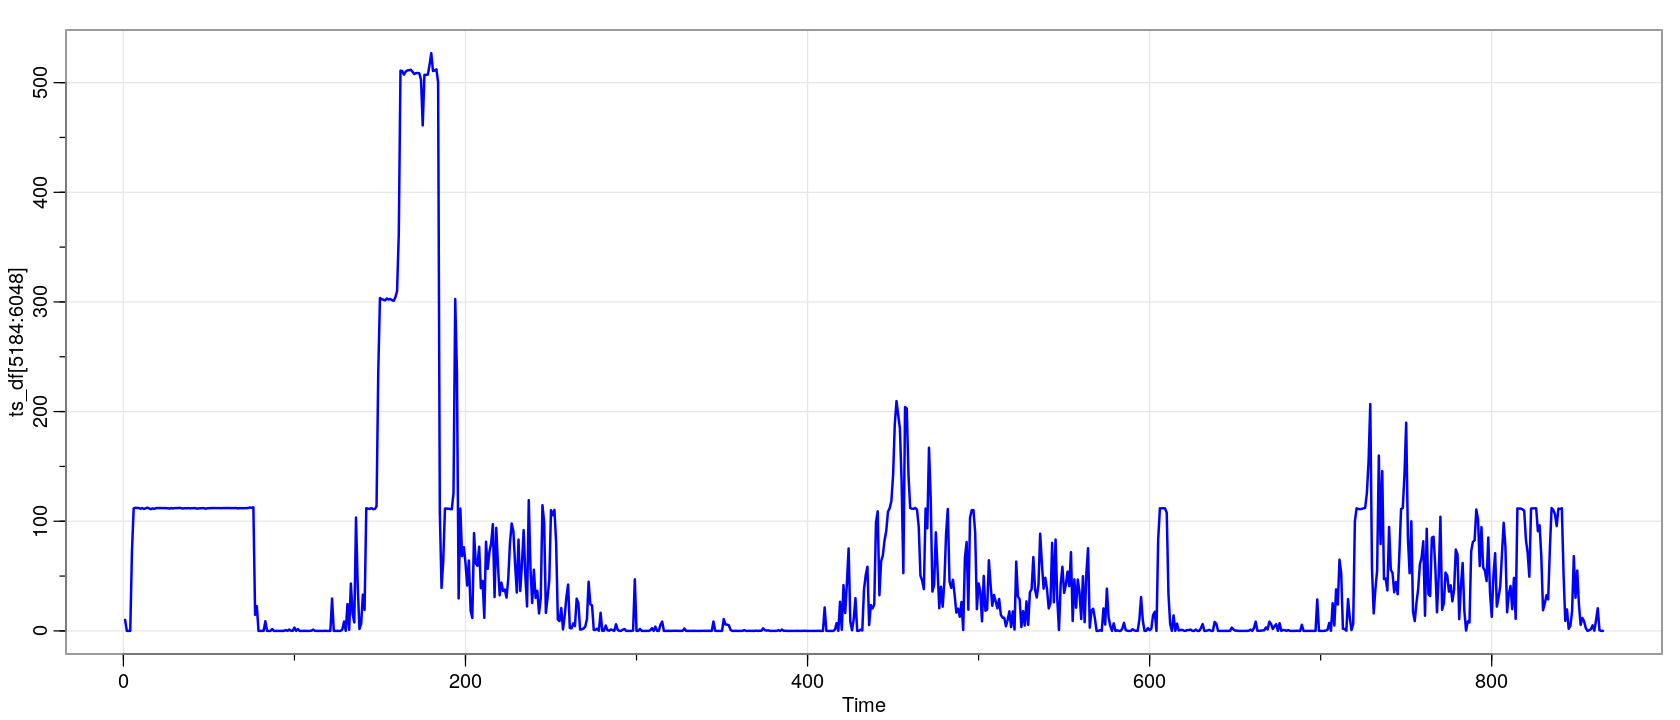

In [9]:
# Hacemos zoom para mostrar los últimos días que queremos predecir
tsplot(ts_df[5184:6048], col=4, lwd=2)

### Particion Train-Test

Definimos el tamaño del dataset para el ajuste start_test en 5184, usa 18 dias (5184/288) para ajustar y nos quedan 3 dias para predecir

In [11]:
start_train = 1
start_test = 5184 
time_series = ts_df

In [12]:
ret = c(0,0)

ts_length = length(time_series)        
end_train = start_test - 1

ts_df_train = ts(time_series[start_train:end_train], start=start_train-1, frequency=1)
ts_df_test = ts(time_series[start_test:ts_length], start=start_test-1, frequency=1)

dn = ts_df_train
dnt = ts_df_test

In [13]:
# Transformamos a log   
# agregamos para probar +1 para evitar log(0)
ldn = log(dn+1)
ldnt = log(dnt+1)
t = time(ldn)

In [14]:
print(head(t))

Time Series:
Start = 0 
End = 5 
Frequency = 1 
[1] 0 1 2 3 4 5


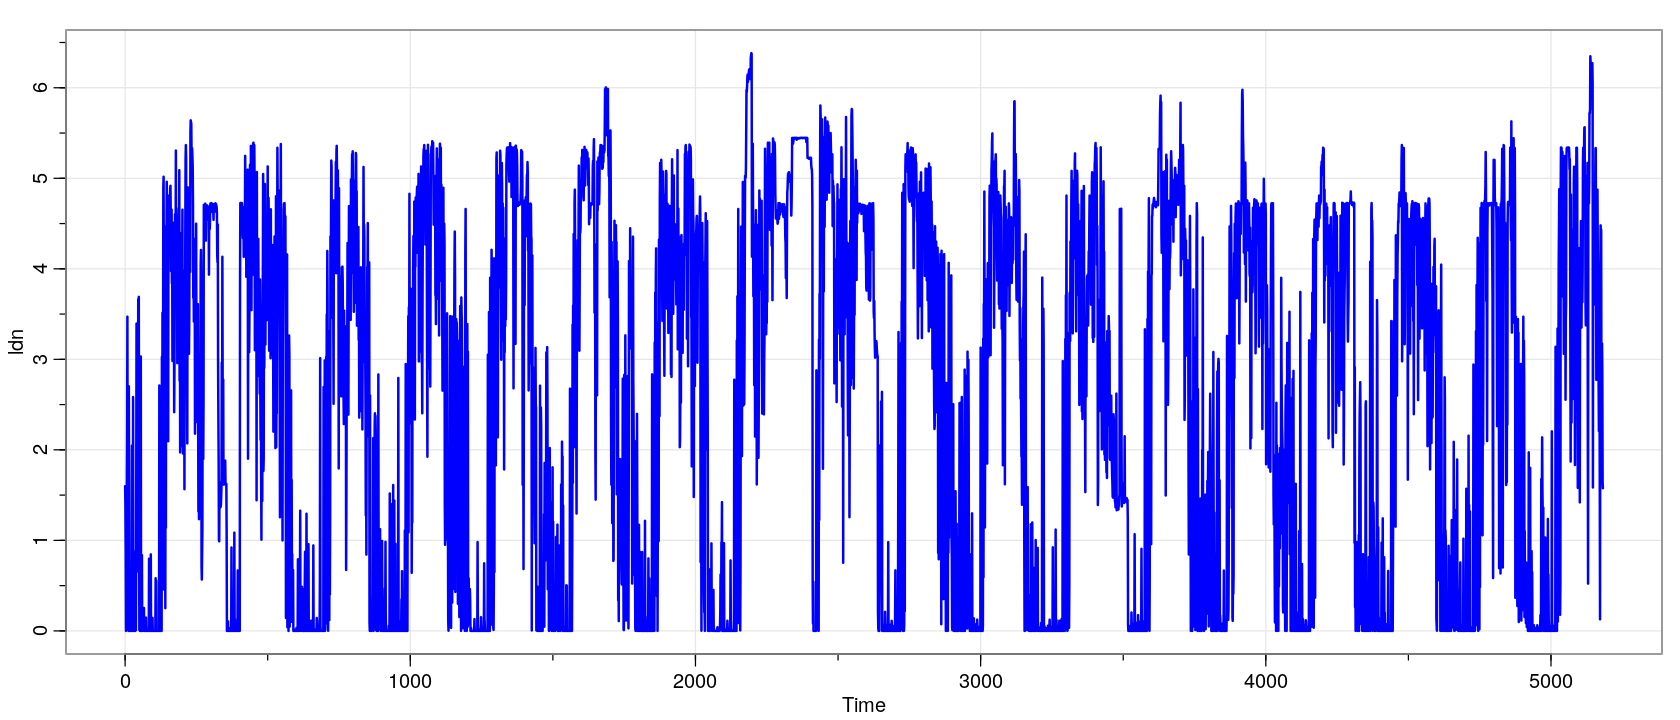

In [15]:
tsplot(ldn, col=4, lwd=2)

### Tendencia

In [16]:
fittrn = lm(ldn ~ t, na.action=NULL)

predicttrend = ts(fitted(fittrn), start=start_train-1, freq=1)

ldnc = ldn-predicttrend
ldnc = ts(ldn-predicttrend, start=start_train-1, freq=1)

In [17]:
summary(fittrn)


Call:
lm(formula = ldn ~ t, na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6436 -2.4954  0.4345  1.9538  3.7952 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.545e+00  5.613e-02  45.332   <2e-16 ***
t           1.973e-05  1.876e-05   1.052    0.293    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.021 on 5181 degrees of freedom
Multiple R-squared:  0.0002134,	Adjusted R-squared:  2.045e-05 
F-statistic: 1.106 on 1 and 5181 DF,  p-value: 0.293


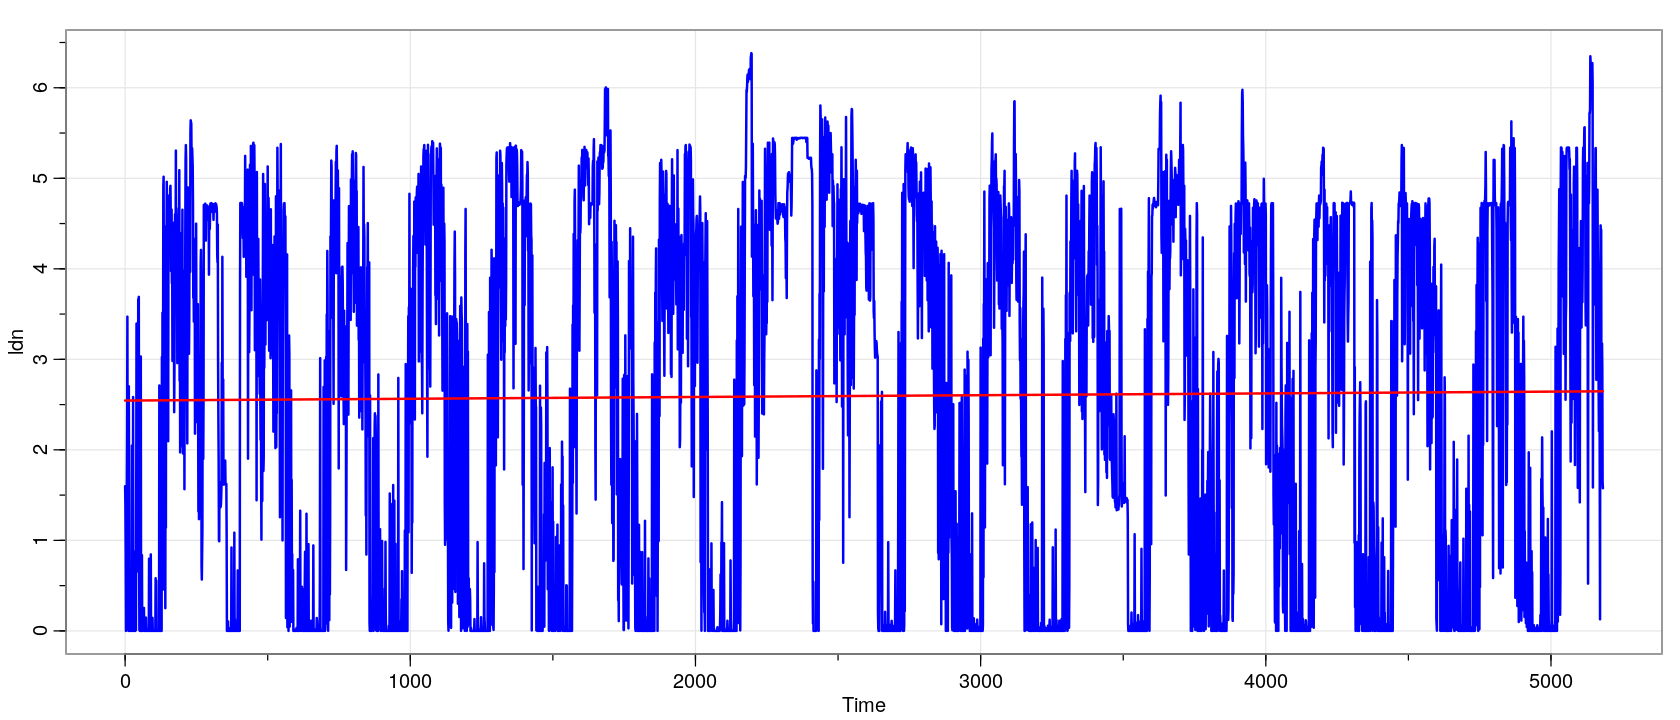

In [18]:
tsplot(ldn, col=4, lwd=2)
lines(predicttrend, col=2, lwd=2)

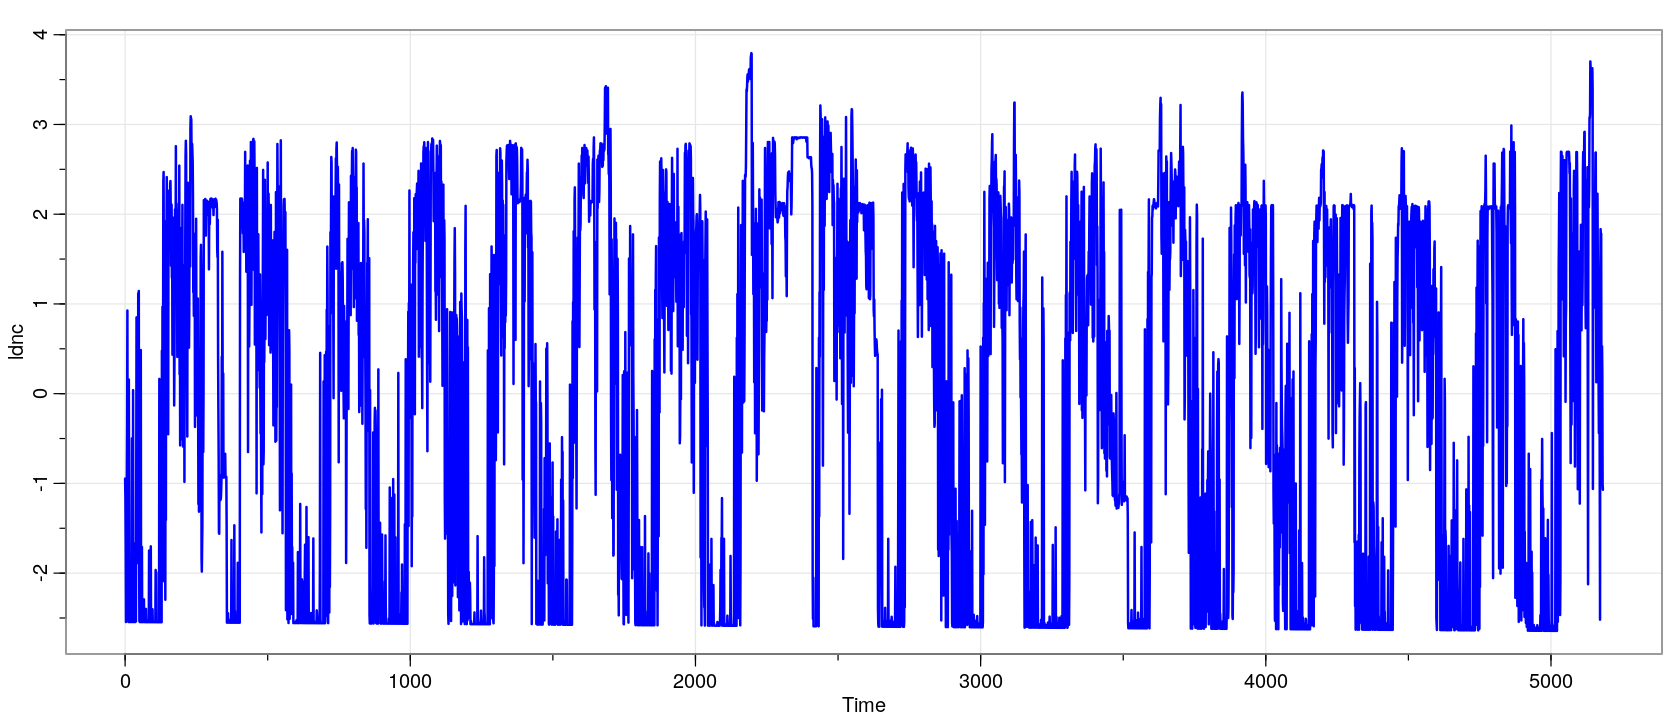

In [41]:
# Ploteamos el residuo, la serie estacionarizada
tsplot(ldnc, col=4, lwd=2)

Tiene sentido que la tendencia sea creciente, por el hecho de que se van sumando usuarios a la plataforma pero no podemos afirmarlo con los datos de un mes

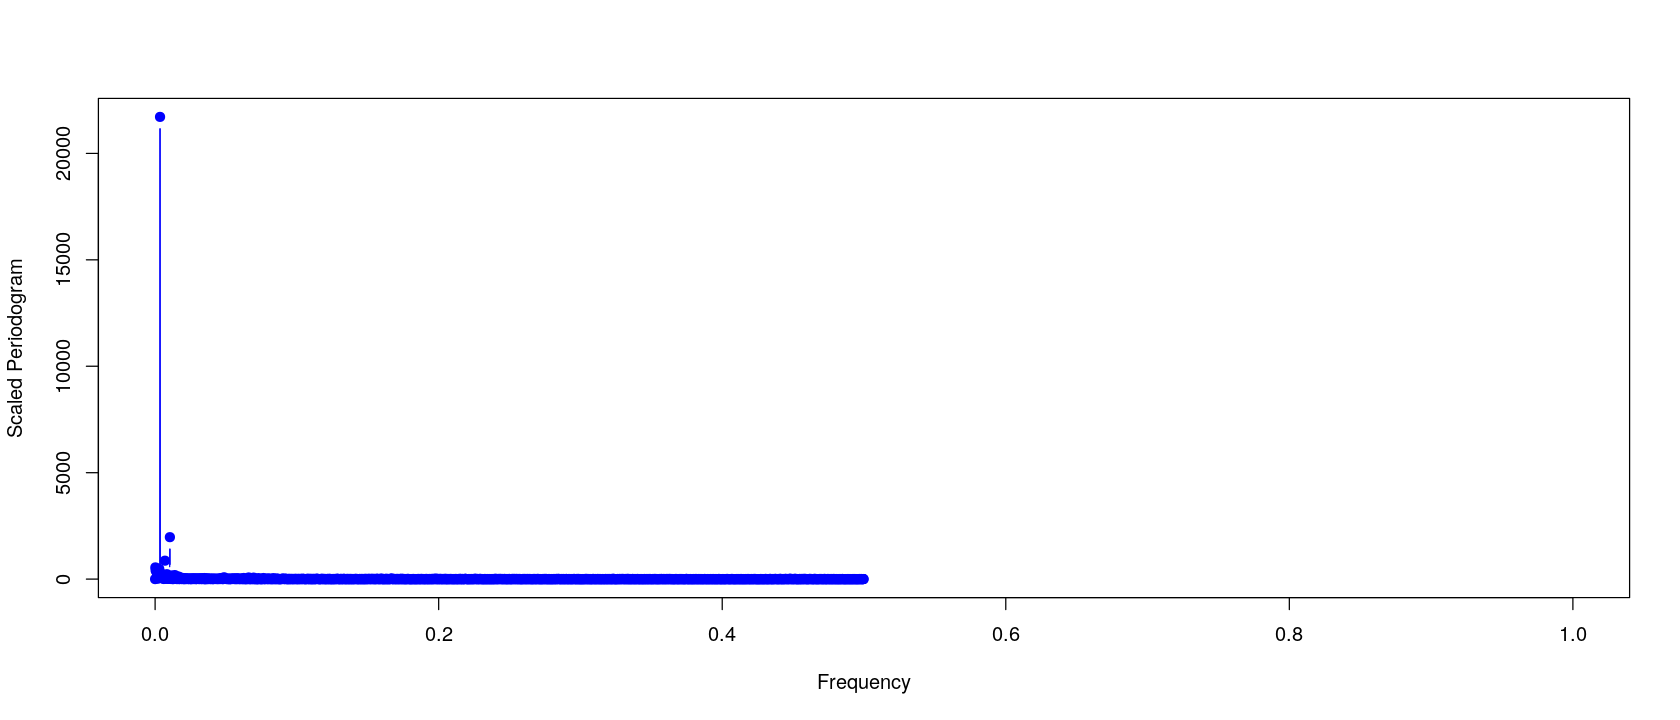

In [43]:
# Periodograma
n=length(ldnc)

P = 4/n*abs(fft(ldnc))^2 
P=P[1:floor(n/2)]#me quedo con las frecuencias posibles
f = (0:(n/2-1))/n 
plot(f,P,  type="b", xlab="Frequency", ylab="Scaled Periodogram", xlim=c(0, 1), col=4, lwd=1, pch=19)

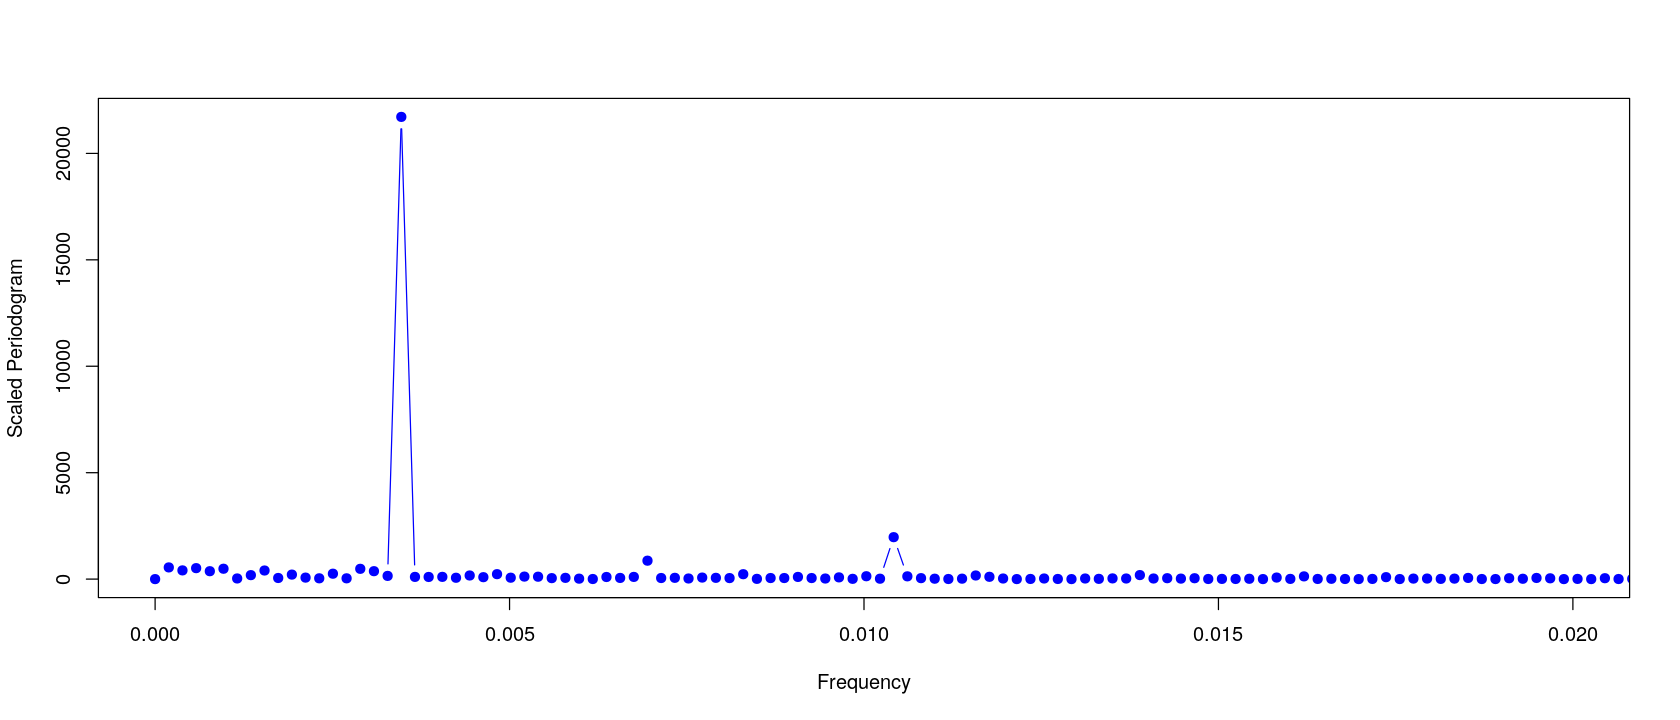

In [44]:
plot(f,P,  type="b", xlab="Frequency", ylab="Scaled Periodogram", xlim=c(0, 0.02), col=4, lwd=1, pch=19)

[1] "0.00347289214740498   21715.3315064483"
[1] "0.00694578429480996   866.084552524173"
[1] "0.0104186764422149   1970.71556742661"


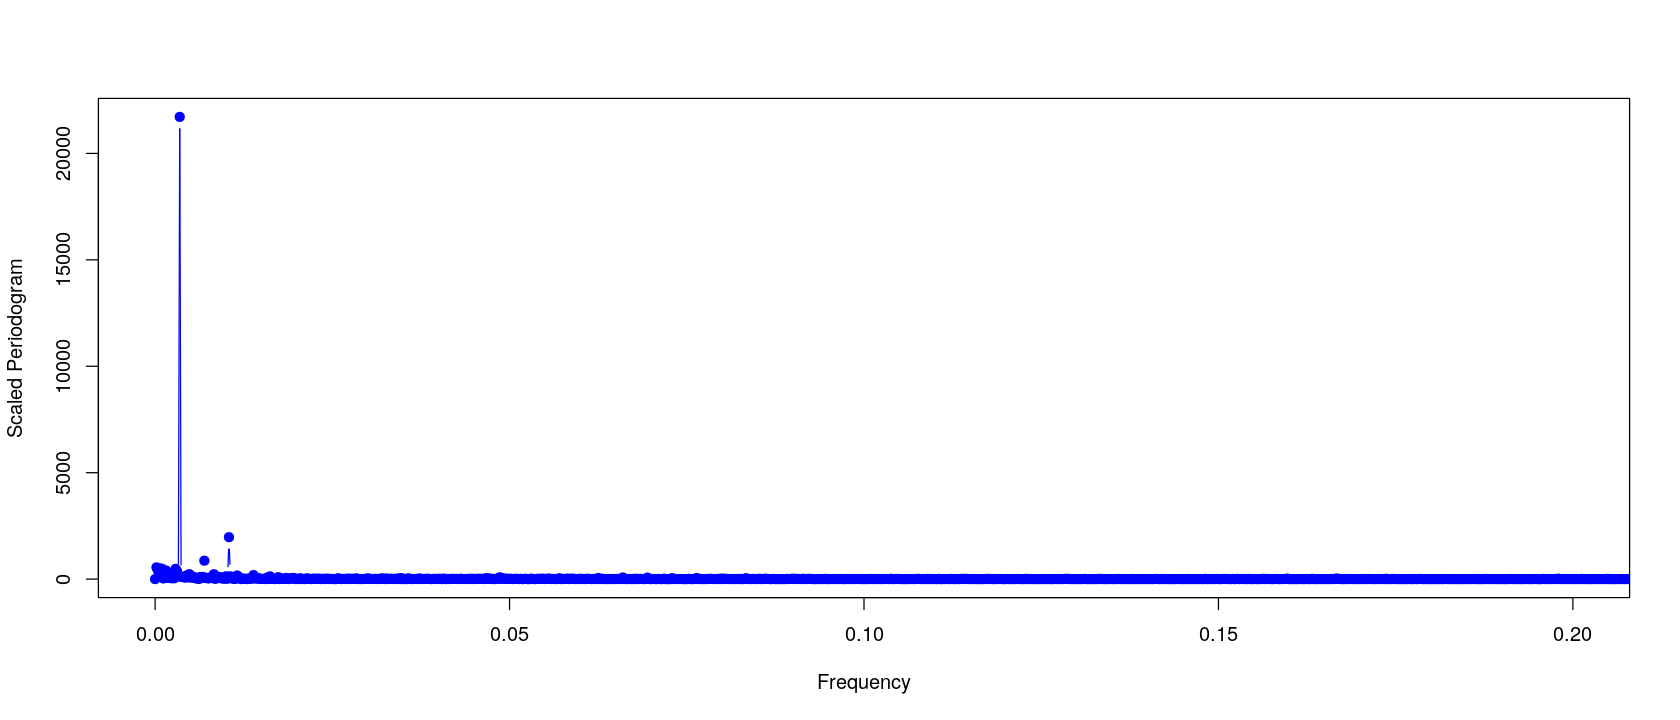

In [45]:
# Imprimimos de nuevo el periodograma de la serie original transformada
plot(f,P,  type="b", xlab="Frequency", ylab="Scaled Periodogram", xlim=c(0, 0.2), col=4, lwd=1, pch=19)

# Nos quedamos con los valores de un umbral que definimos a partir de las primeras observaciones del periodograma
# para elegir las frecuencias ajusto el limite de frecuencias a 0.2
P_thresh = 550 # umbral del eje y 
max_freq_idx = length(f)

for (i in (1:max_freq_idx)){
    if (P[i] > P_thresh & f[i] < .2) {
        print(paste(f[i], " " ,P[i]))
        }
}

In [46]:
t = time(ldnc) 


f1 = 0.003473
f2 = 0.006946
f3 = 0.010419

fit = lm(ldnc ~ 0 + cos(2*pi*f1*t) + sin(2*pi*f1*t) +
                    cos(2*pi*f2*t) + sin(2*pi*f2*t) +
                    cos(2*pi*f3*t) + sin(2*pi*f3*t) ,
         na.action=NULL)

prediction = ts(fitted(fit), start=start_train-1, freq=1)

tn = start_test - 1 

res = (ts(residuals(fit), start=start_train -1, freq=1))

In [47]:
summary(fit)


Call:
lm(formula = ldnc ~ 0 + cos(2 * pi * f1 * t) + sin(2 * pi * f1 * 
    t) + cos(2 * pi * f2 * t) + sin(2 * pi * f2 * t) + cos(2 * 
    pi * f3 * t) + sin(2 * pi * f3 * t), na.action = NULL)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7985 -0.8809 -0.0984  0.7018  5.2646 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
cos(2 * pi * f1 * t) -0.14528    0.02573  -5.646 1.73e-08 ***
sin(2 * pi * f1 * t) -2.04181    0.02573 -79.354  < 2e-16 ***
cos(2 * pi * f2 * t)  0.19837    0.02573   7.710 1.50e-14 ***
sin(2 * pi * f2 * t)  0.35731    0.02573  13.887  < 2e-16 ***
cos(2 * pi * f3 * t) -0.42589    0.02573 -16.552  < 2e-16 ***
sin(2 * pi * f3 * t) -0.44545    0.02573 -17.312  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.31 on 5177 degrees of freedom
Multiple R-squared:  0.5802,	Adjusted R-squared:  0.5797 
F-statistic:  1192 on 6 and 5177 DF,  p-value: < 2.2e-16


Encontramos todos los coeficientes de las frecuencias significativos, con las tres frecuencias que encontramos queda explicado el 58% de la varianza de la serie.

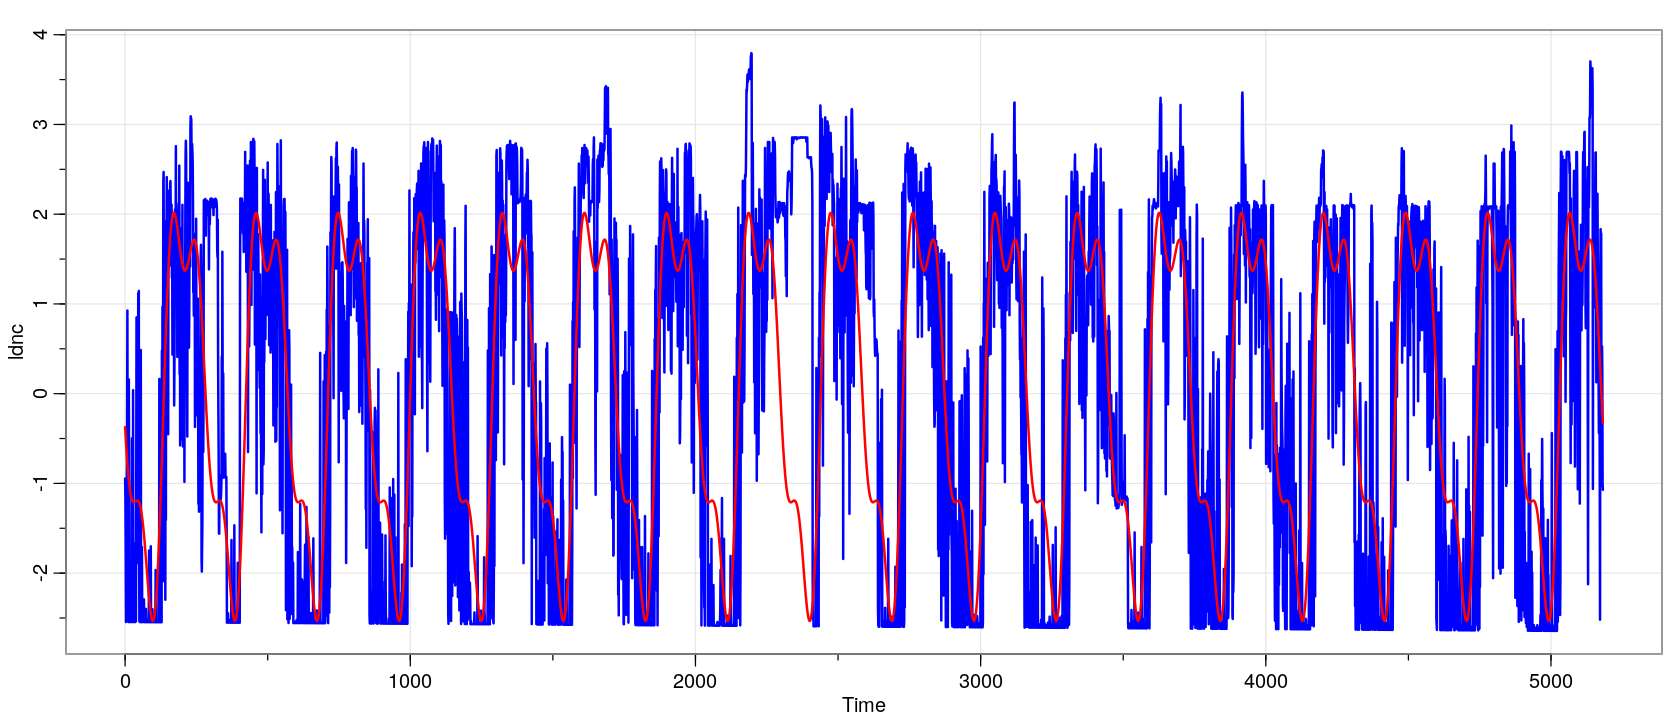

In [49]:
tsplot(ldnc, col=4, lwd=2)
lines(prediction, col=2, lwd=2)

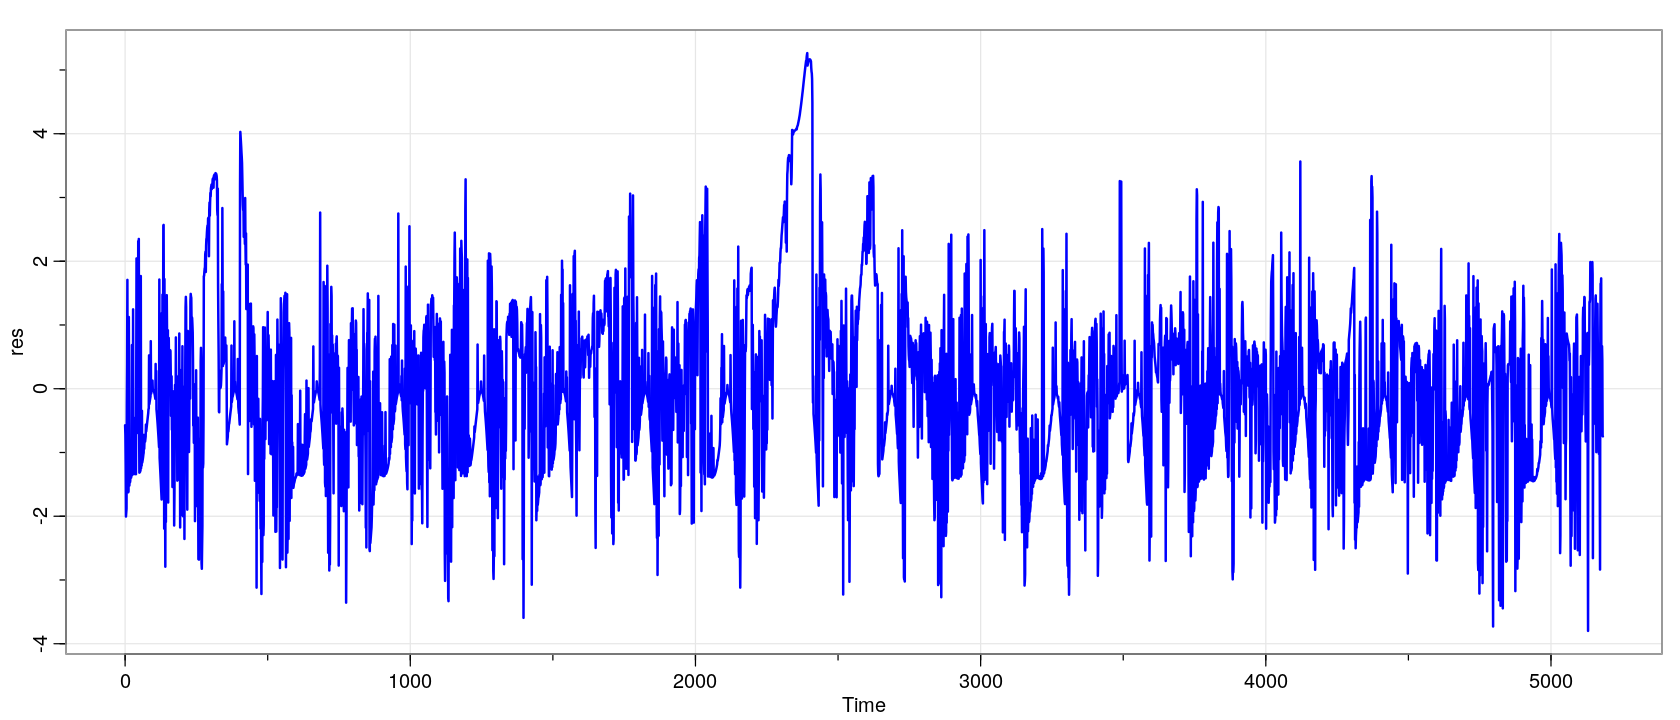

In [51]:
# Ploteamos los residuos de la serie
tsplot(res, col=4, lwd=2)

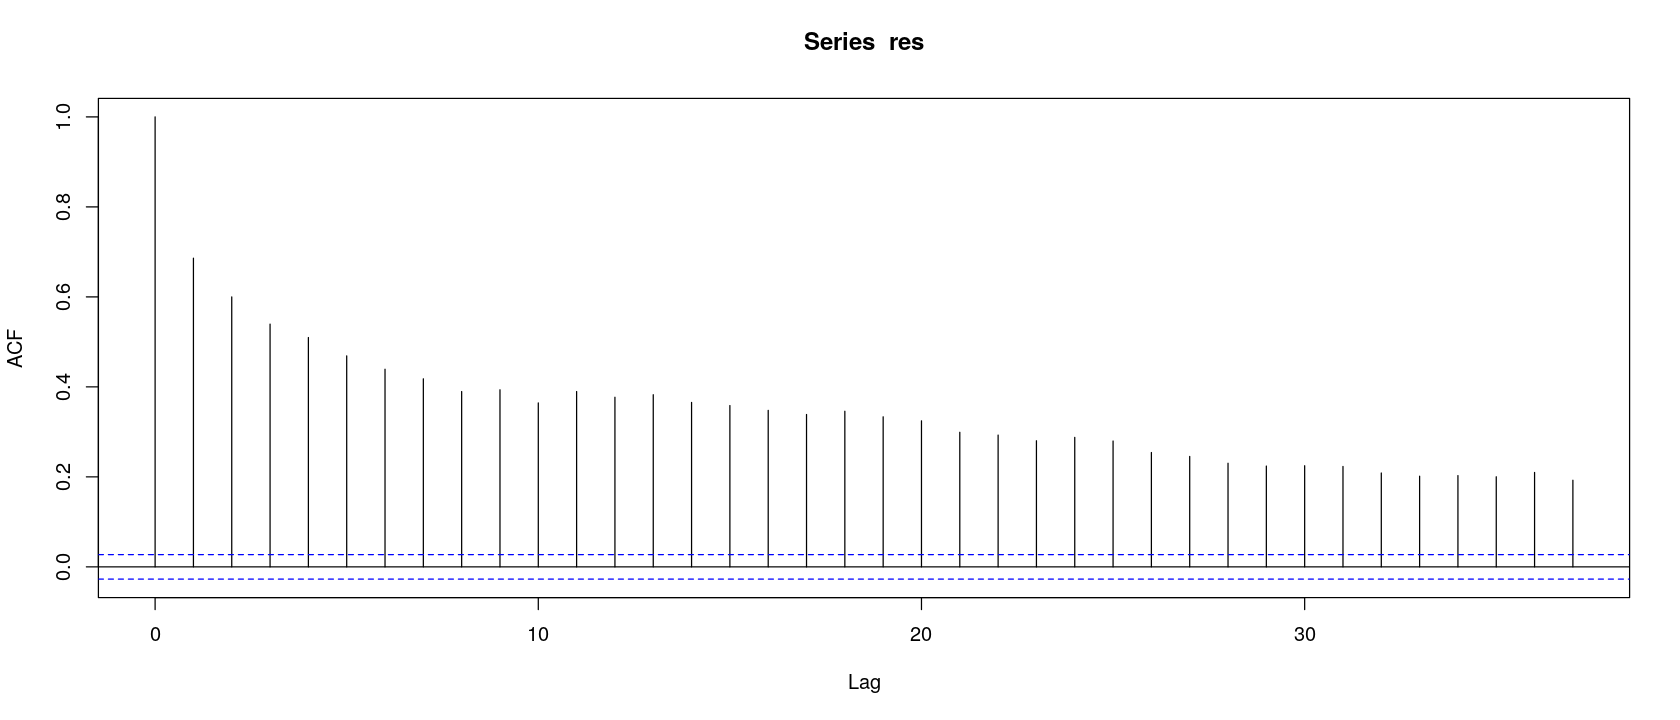

In [53]:
acf(res)

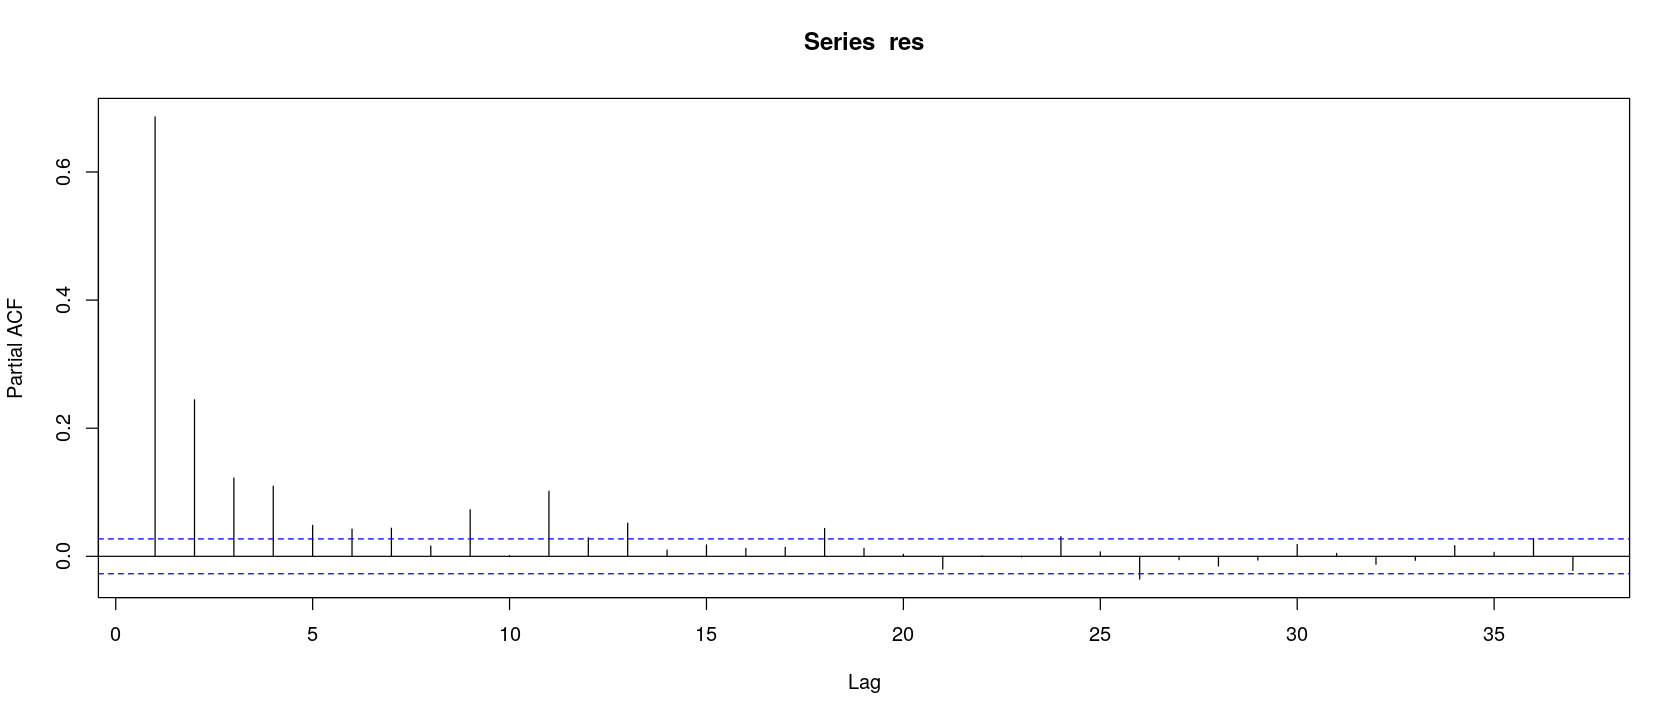

In [54]:
pacf(res)

Comenzamos probando con un AR de órden 7, de acuerdo al resultado del acf y pacf de los residuos del ajuste de las componentes periódicas vimos que acf decae exponencialmente y pacf corta en 7.


#### Ajuste AR(7)

Series: ldncr1 
ARIMA(7,0,0) with zero mean 

Coefficients:
         ar1     ar2     ar3     ar4     ar5     ar6     ar7
      0.4657  0.1528  0.0548  0.0773  0.0217  0.0222  0.0437
s.e.  0.0139  0.0153  0.0154  0.0154  0.0154  0.0153  0.0139

sigma^2 estimated as 0.8263:  log likelihood=-6856.72
AIC=13729.44   AICc=13729.46   BIC=13781.86

Training set error measures:
                       ME      RMSE       MAE      MPE     MAPE      MASE
Training set 7.512722e-06 0.9083735 0.6380347 54.74792 191.2064 0.9988393
                     ACF1
Training set -0.000578822

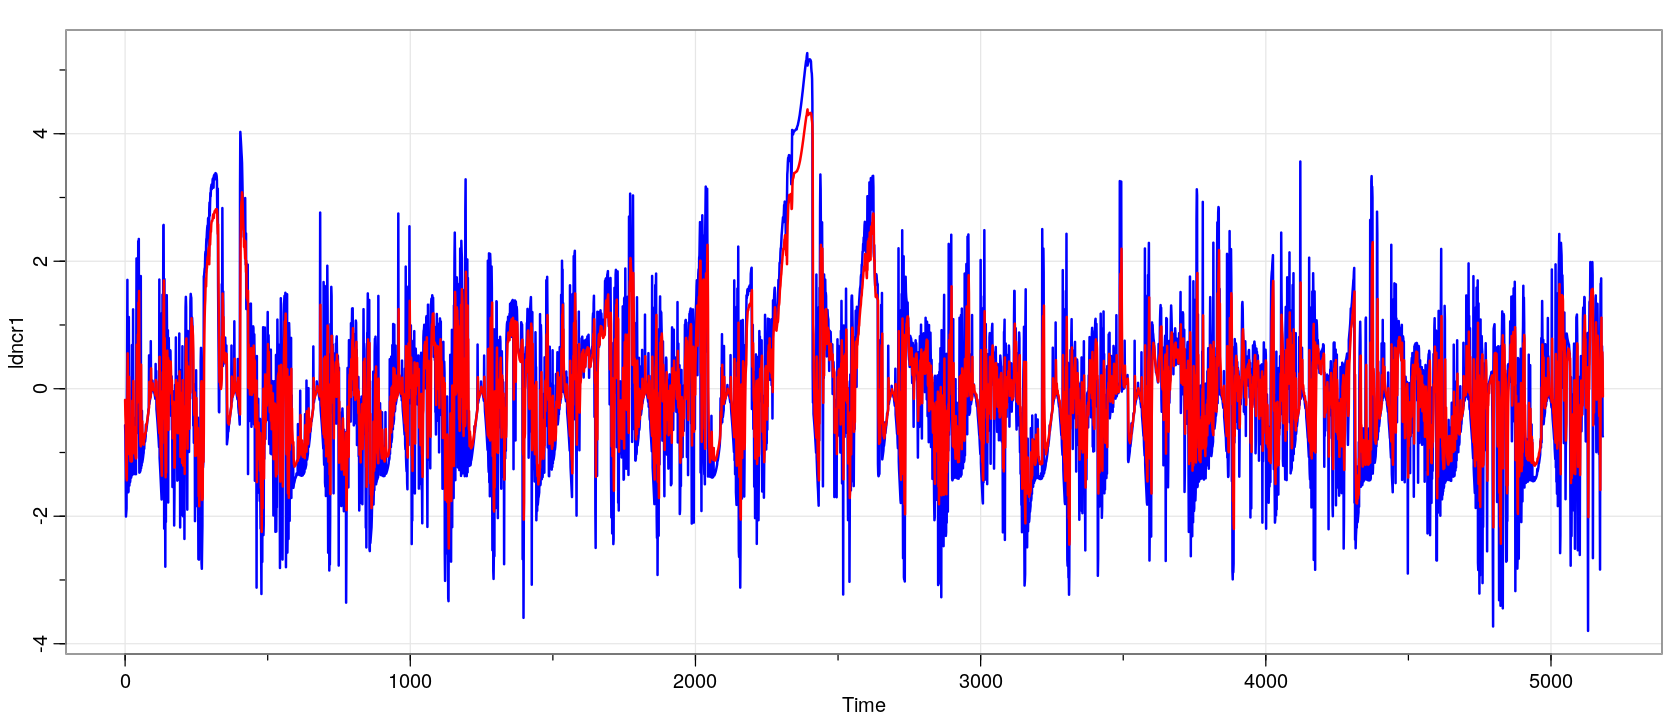

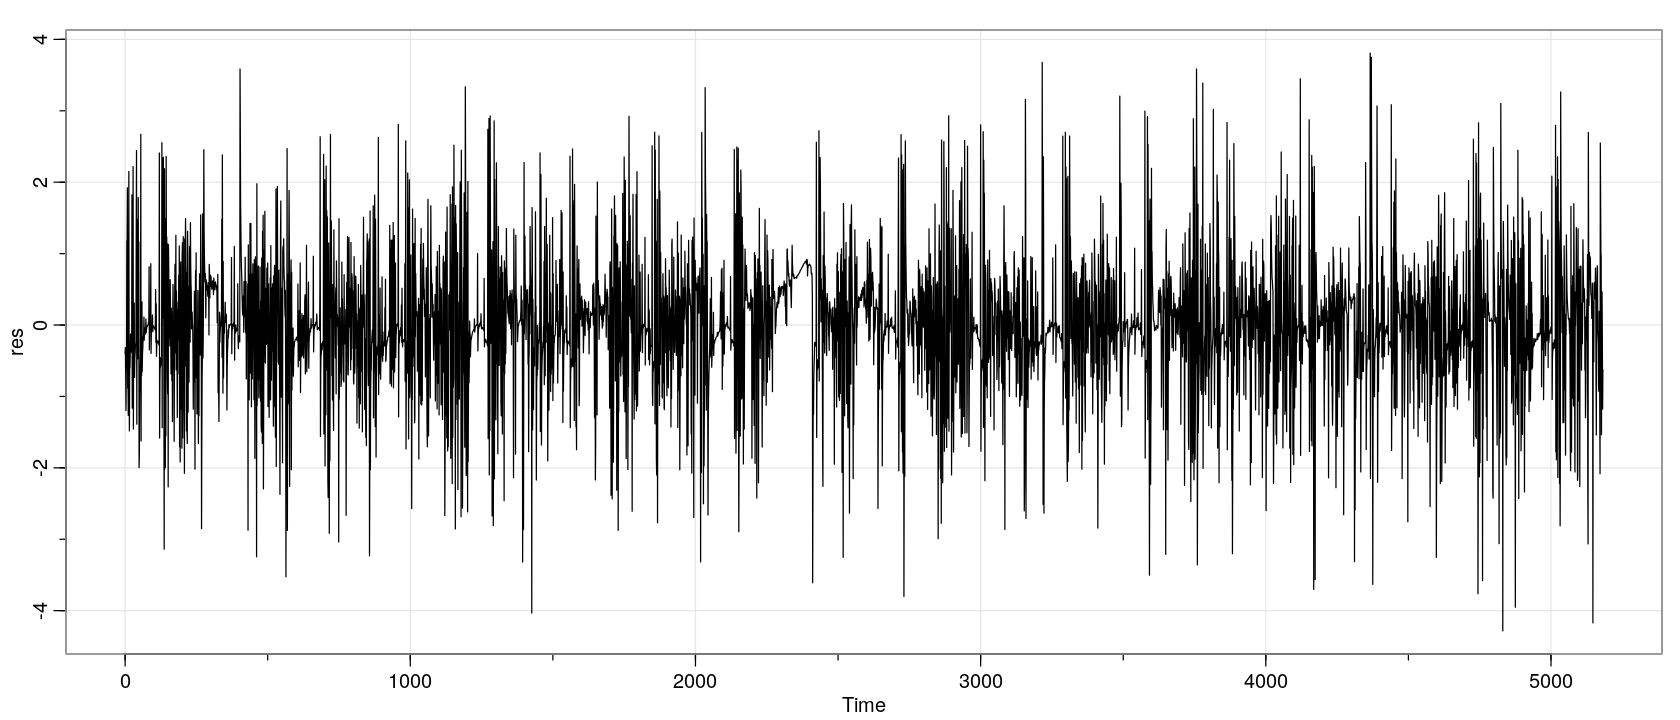

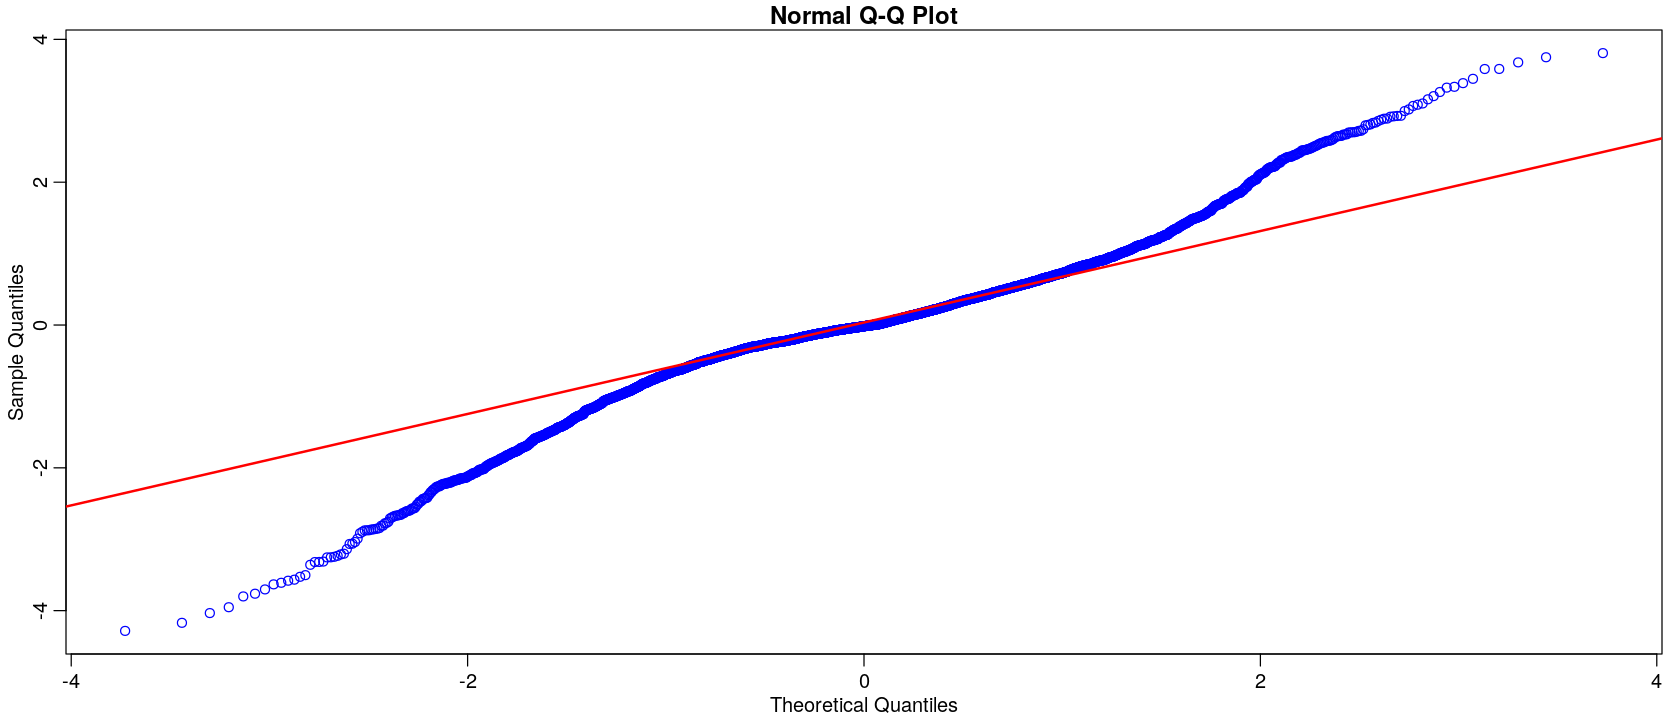

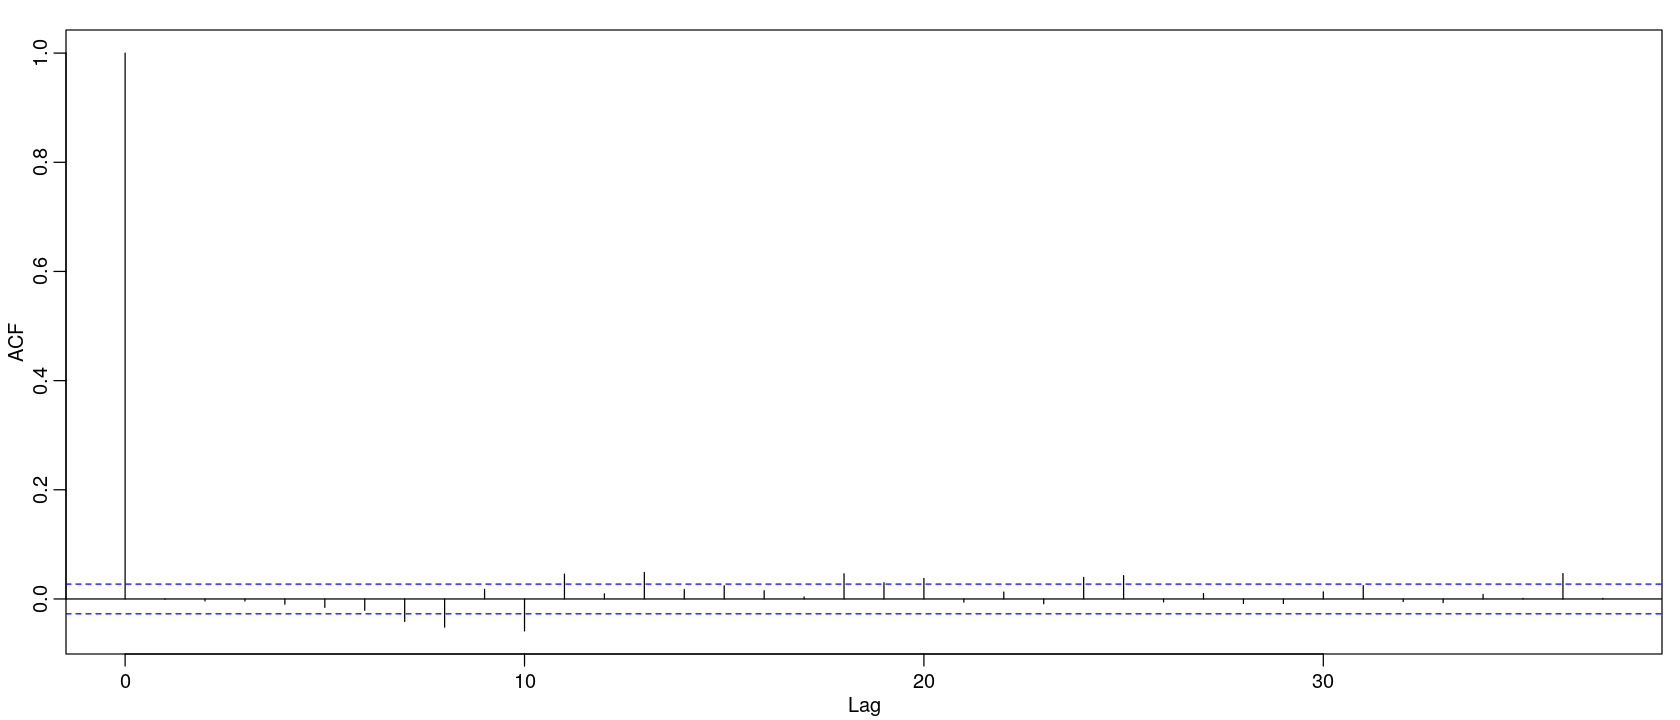

In [72]:
ldncr1 = res
        
fit = Arima(ldncr1, order = c(7,0,0), include.mean=FALSE)
summary(fit)
tsplot(ldncr1, col=4, lwd=2)
lines(fitted(fit), col=2, lwd=2)
res = residuals(fit)
tsplot(res)
qqnorm(res, col=4)
qqline(res, col=2, lwd=2)
acf(residuals(fit))

Obtuvimos 2 coeficientes no significativos, entonces probamos AR con órden 6, 5 y 4.

#### Ajuste AR(6)

Series: ldncr1 
ARIMA(6,0,0) with zero mean 

Coefficients:
         ar1     ar2     ar3     ar4     ar5     ar6
      0.4675  0.1541  0.0583  0.0799  0.0285  0.0427
s.e.  0.0139  0.0153  0.0154  0.0154  0.0153  0.0139

sigma^2 estimated as 0.8277:  log likelihood=-6861.67
AIC=13737.35   AICc=13737.37   BIC=13783.22

Training set error measures:
                        ME      RMSE       MAE      MPE   MAPE      MASE
Training set -1.947069e-05 0.9092436 0.6380043 59.32708 188.64 0.9987917
                     ACF1
Training set -0.001775459

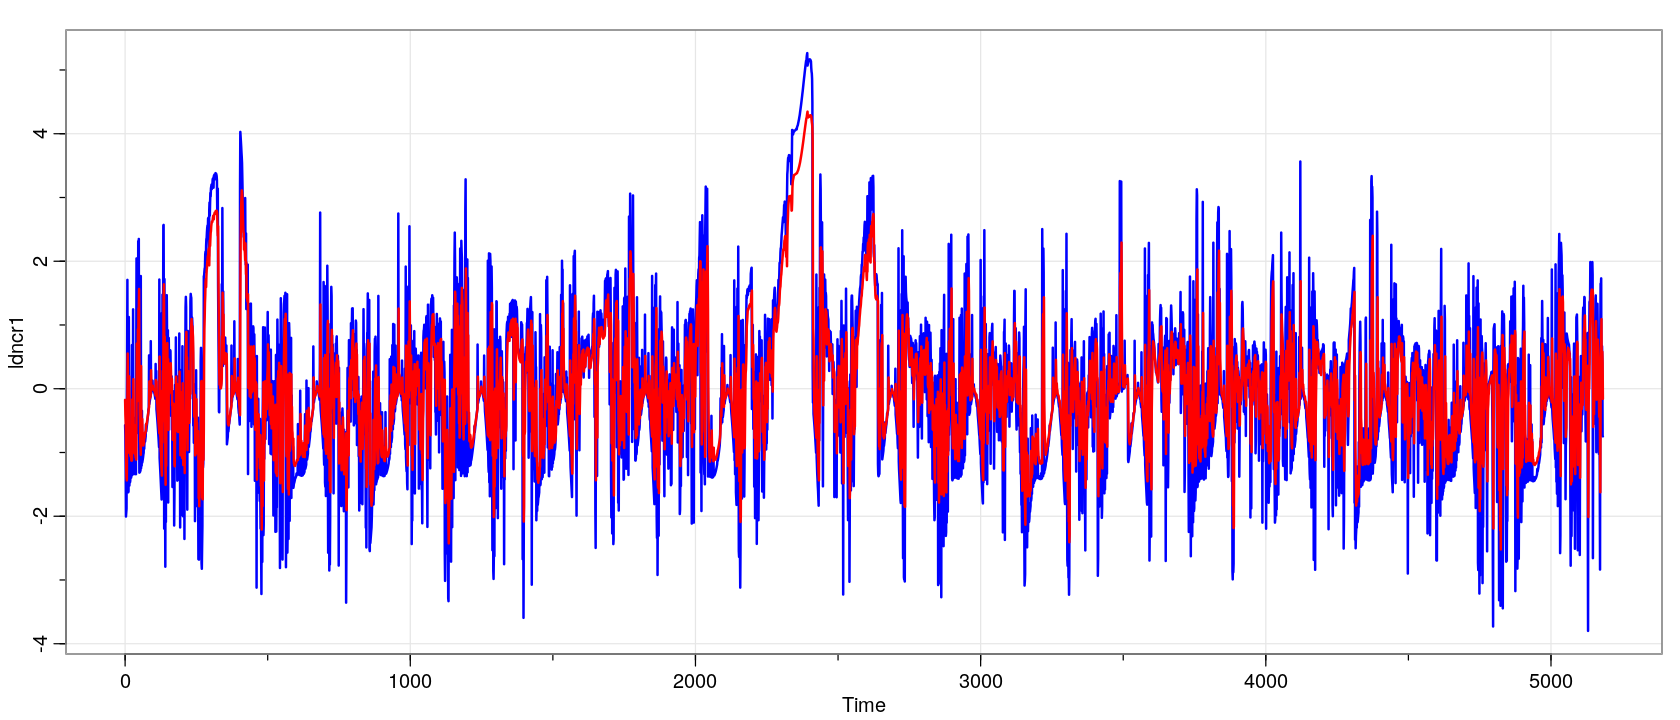

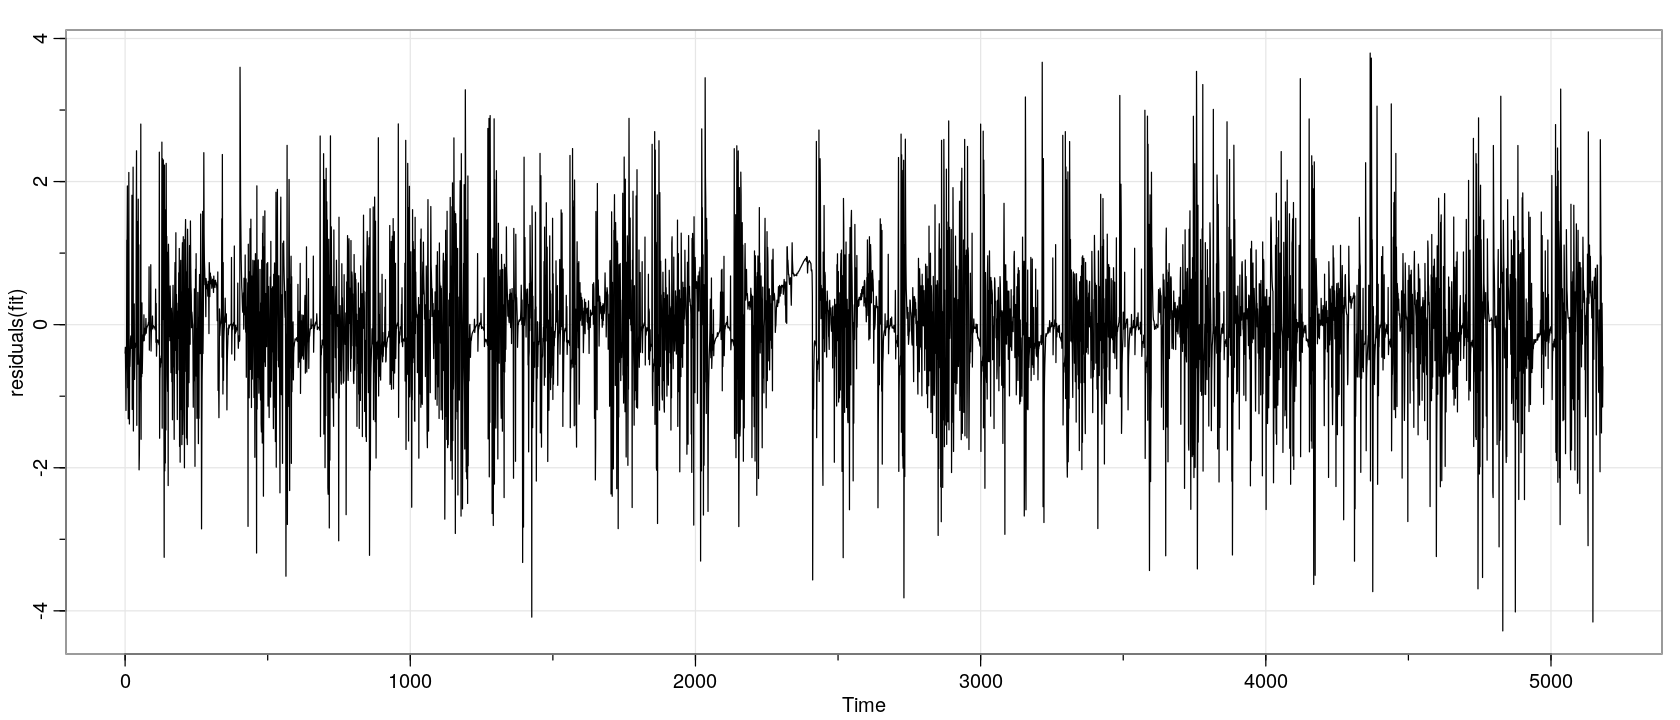

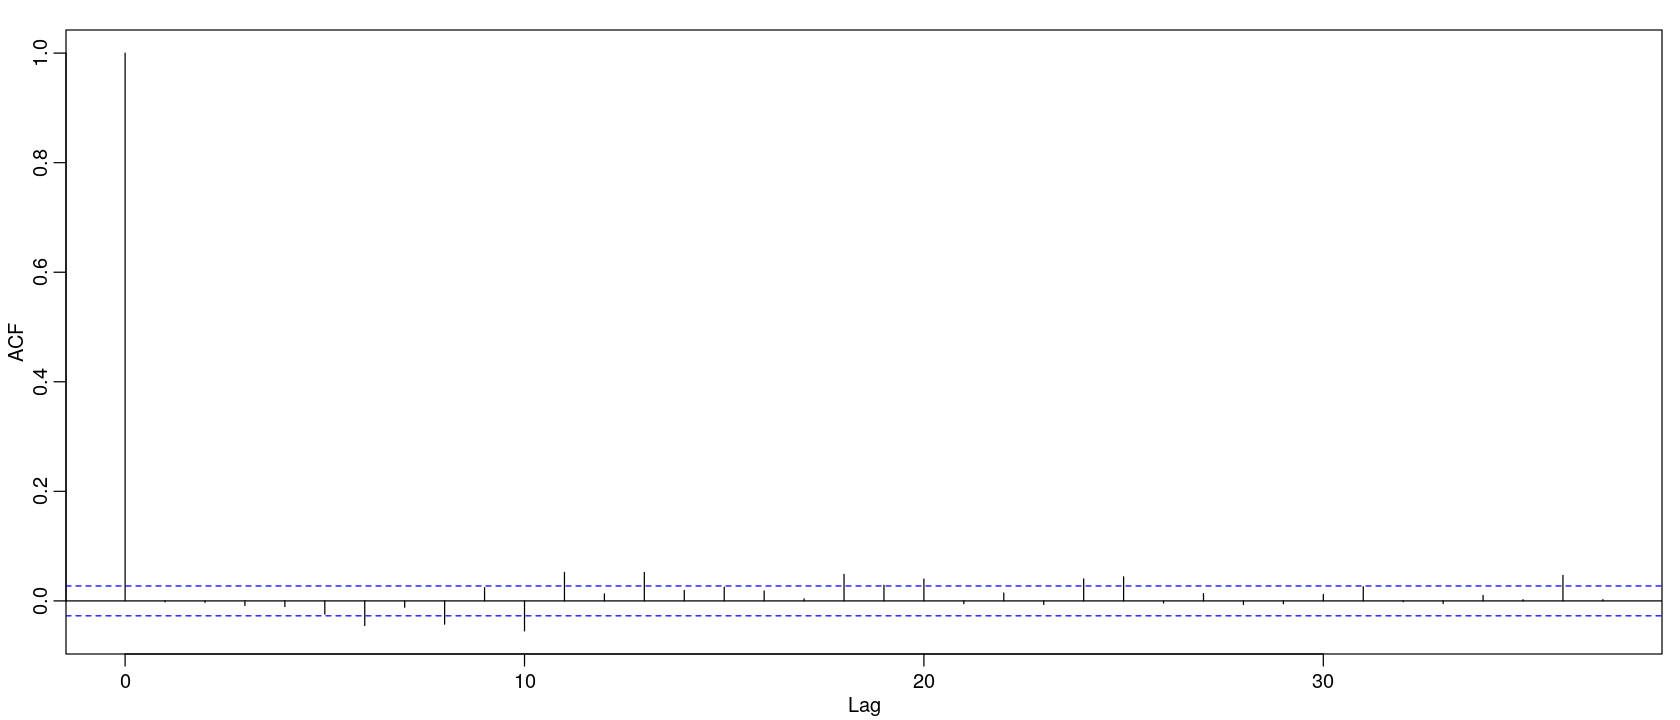

In [57]:
fit = Arima(ldncr1, order = c(6,0,0), include.mean=FALSE)
summary(fit)
tsplot(ldncr1, col=4, lwd=2)
lines(fitted(fit), col=2, lwd=2)
tsplot(residuals(fit))
acf(residuals(fit))

#### Ajuste AR(5)

Series: ldncr1 
ARIMA(5,0,0) with zero mean 

Coefficients:
         ar1     ar2     ar3     ar4     ar5
      0.4696  0.1577  0.0609  0.0866  0.0485
s.e.  0.0139  0.0153  0.0154  0.0153  0.0139

sigma^2 estimated as 0.829:  log likelihood=-6866.4
AIC=13744.79   AICc=13744.81   BIC=13784.11

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE      MASE
Training set -2.935708e-05 0.9100736 0.6385655 62.94482 186.7103 0.9996702
                     ACF1
Training set -0.001981949

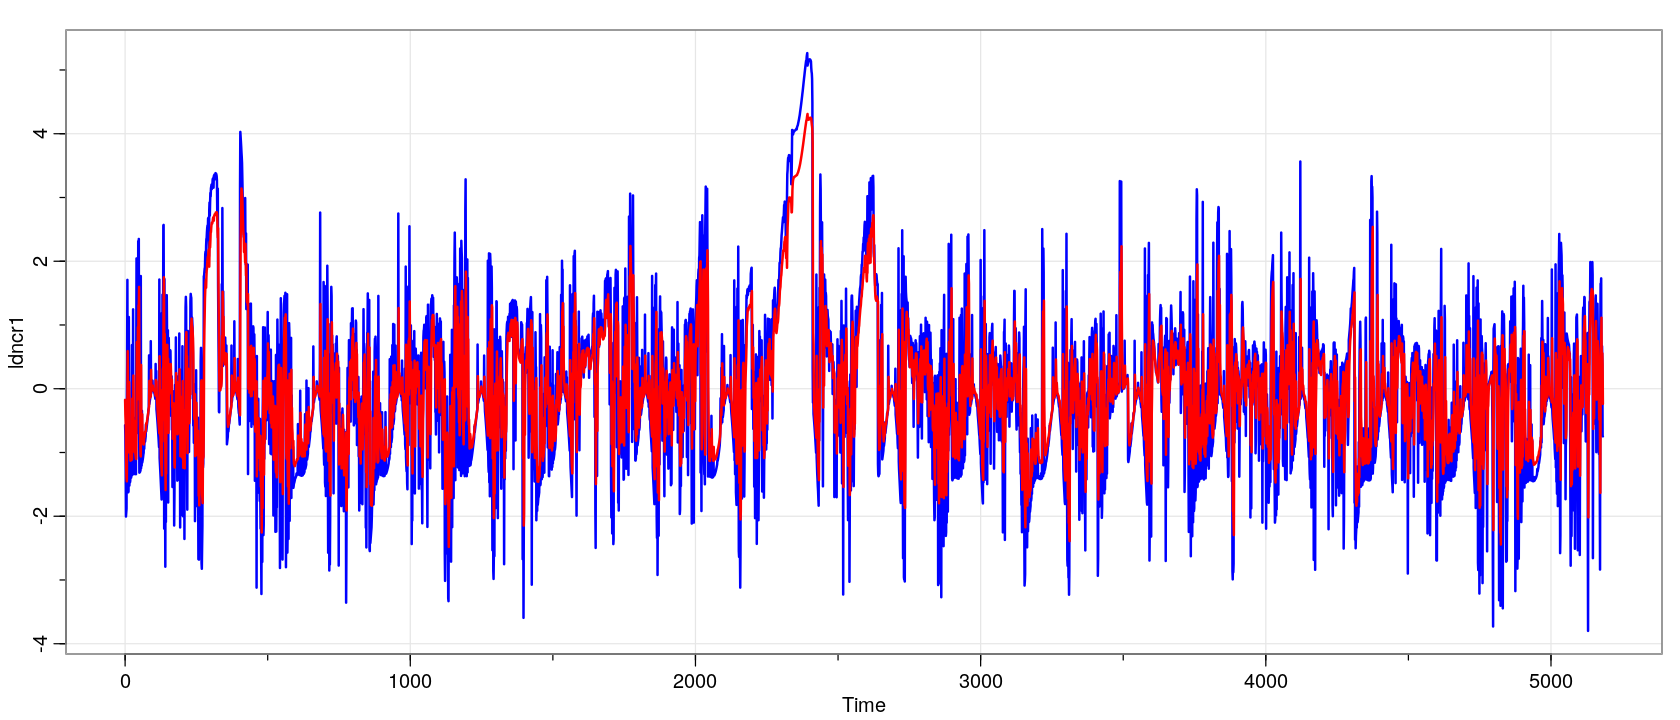

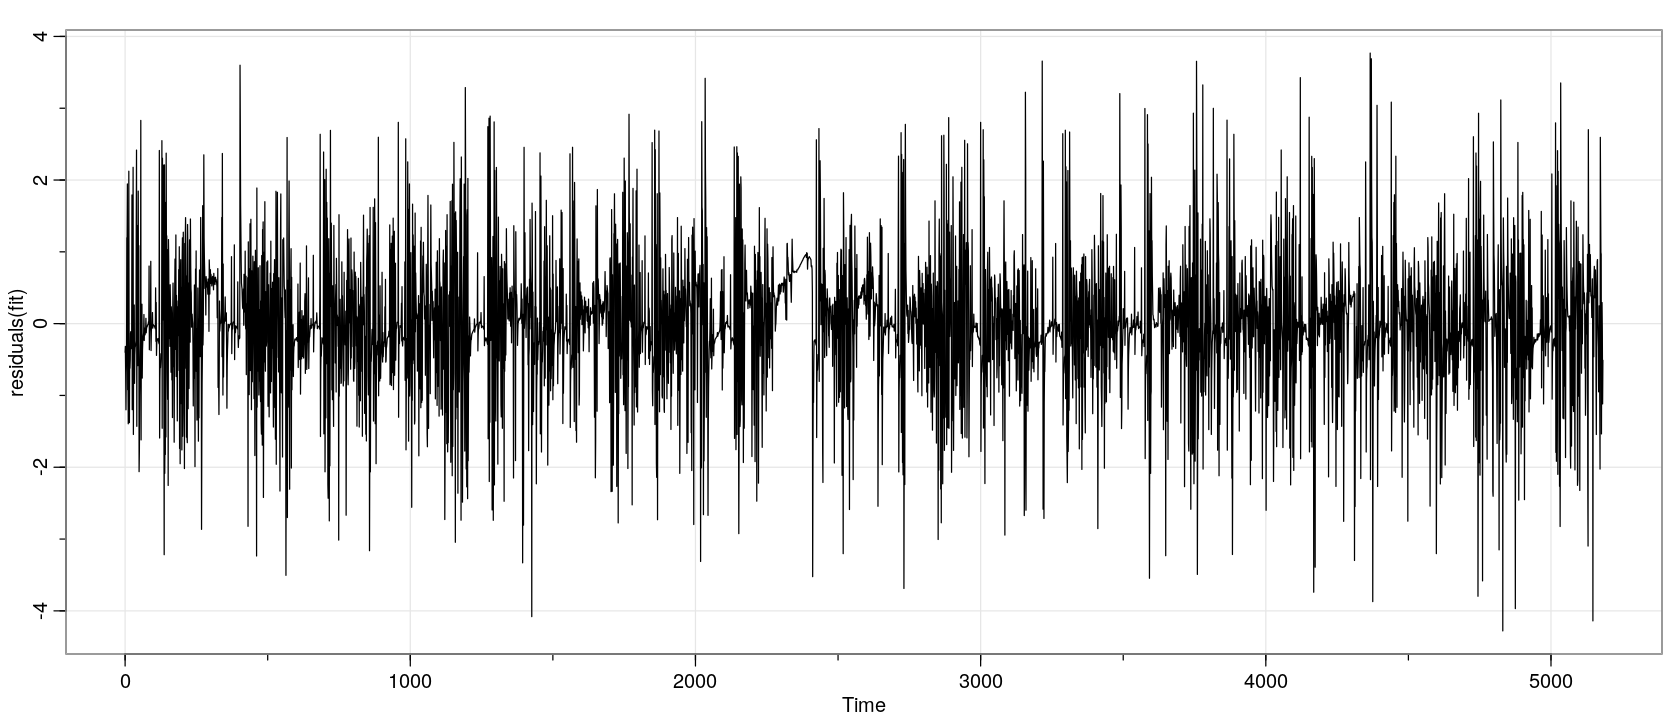

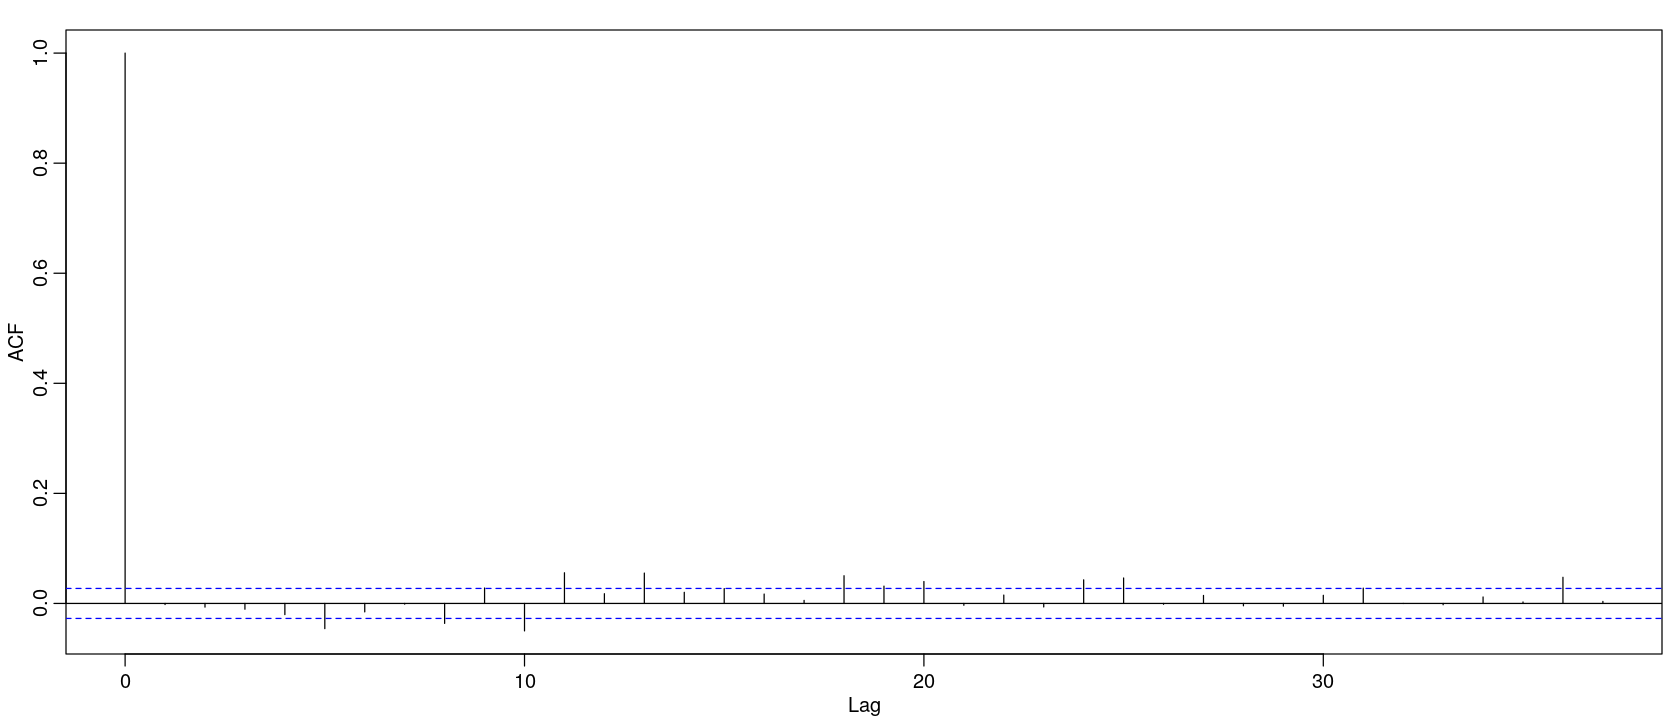

In [58]:
fit = Arima(ldncr1, order = c(5,0,0), include.mean=FALSE)
summary(fit)
tsplot(ldncr1, col=4, lwd=2)
lines(fitted(fit), col=2, lwd=2)
tsplot(residuals(fit))
acf(residuals(fit))

#### Ajuste AR(4)

Series: ldncr1 
ARIMA(4,0,0) with zero mean 

Coefficients:
         ar1     ar2     ar3     ar4
      0.4749  0.1611  0.0687  0.1097
s.e.  0.0138  0.0153  0.0153  0.0138

sigma^2 estimated as 0.8308:  log likelihood=-6872.5
AIC=13755   AICc=13755.01   BIC=13787.77

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE     MASE
Training set -4.452313e-05 0.9111471 0.6388454 65.50802 183.8188 1.000108
                     ACF1
Training set -0.005232773

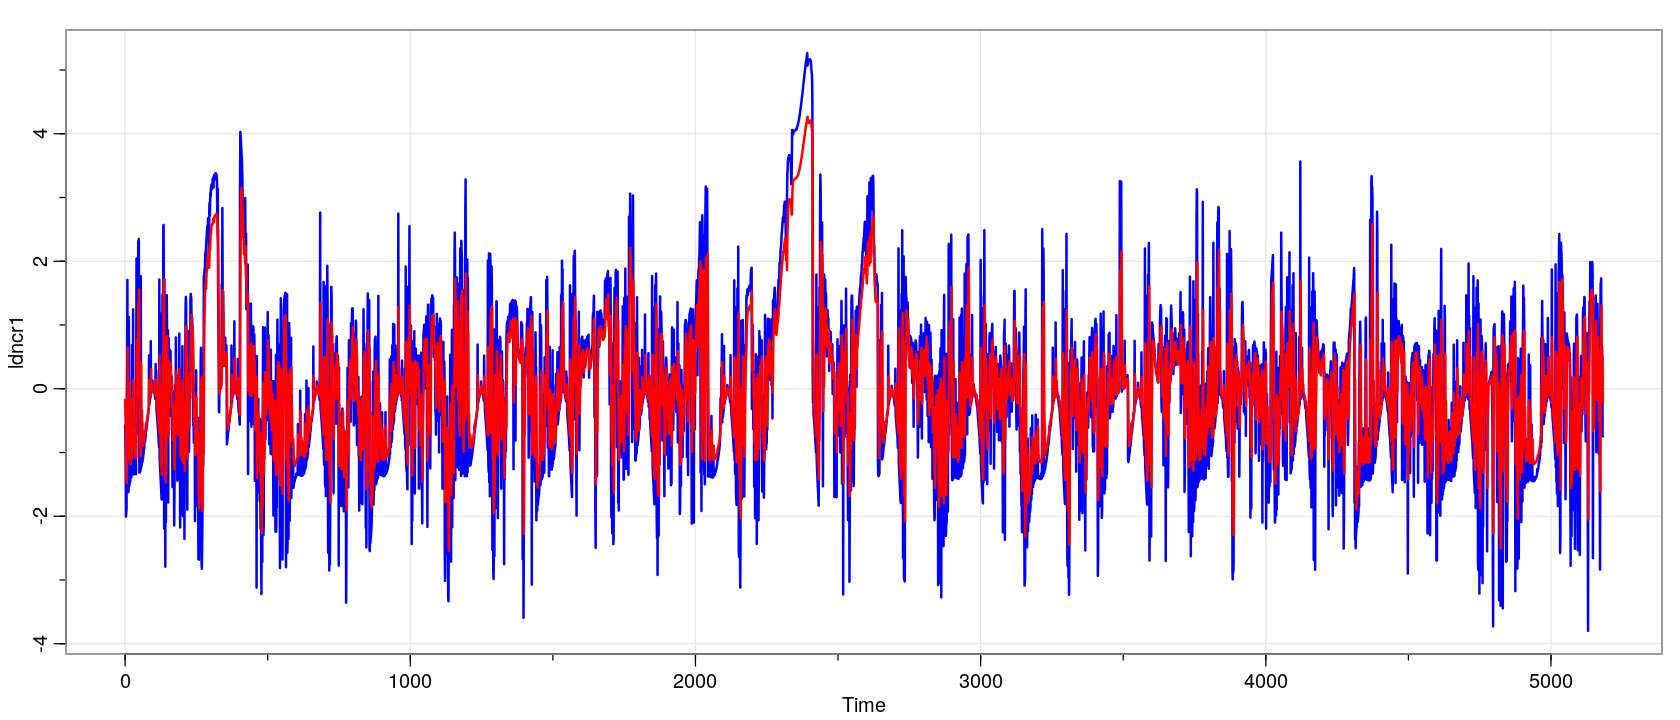

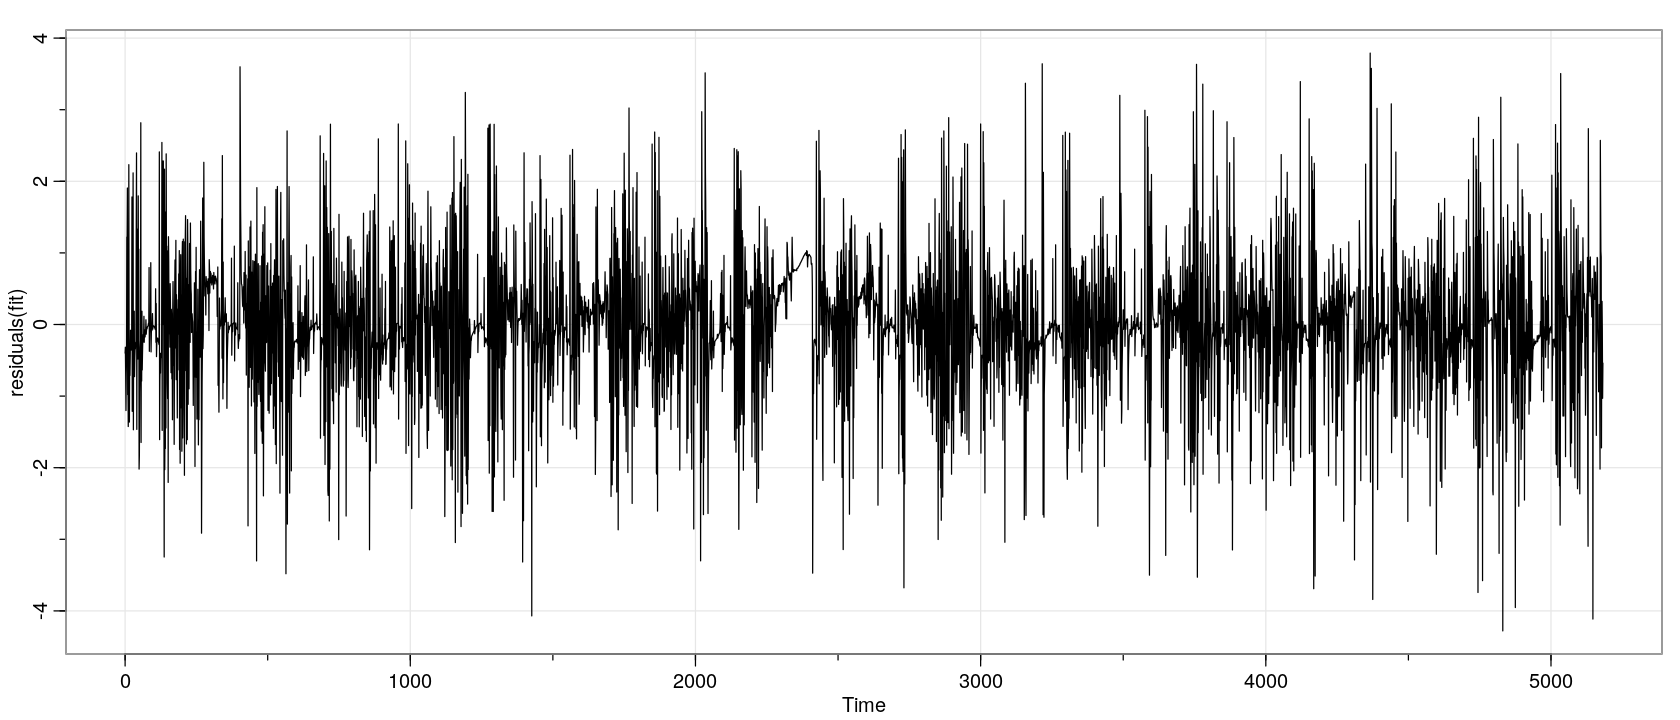

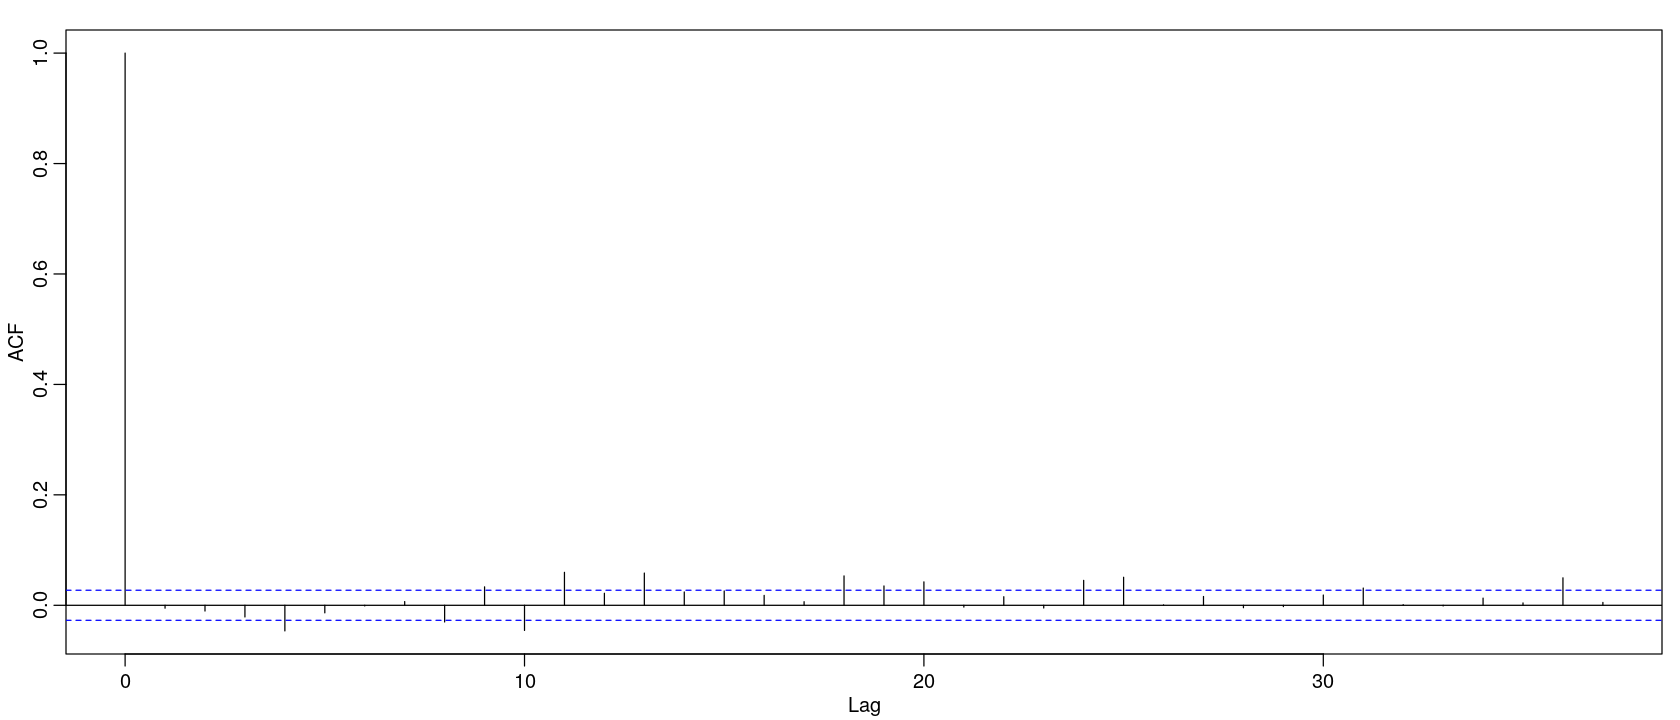

In [59]:
fit = Arima(ldncr1, order = c(4,0,0), include.mean=FALSE)
summary(fit)
tsplot(ldncr1, col=4, lwd=2)
lines(fitted(fit), col=2, lwd=2)
tsplot(residuals(fit))
acf(residuals(fit))

In [ ]:
# del ajuste de estos tres modelos ARs, observamos que el AR(5) performa mejor, tiene todos sus coeficientes
# significativos (el AR(6) tiene uno no significativo), poderamos el hecho de que todos los coeficientes sean 
# significativos a pesar de que el AIC devuelve un mejor resultado en el AR(6) 
# El AR(4) lo descartamos porque da un peor AIC respecto al AR(5)

In [ ]:
# Respecto al residuo que obtenemos del fit del AR(5), si bien tiene algunas autocorrelaciones en lags que
# sobresalen levemente del intervalo de confianza (con el criterio del 95% en 20 lags), 
# entendemos que el resultado tiende a ser ruido blanco
# De cualquier manera en la sección siguiente hacemos pruebas con otros modelos de los cuales si obtenemos ruido 
# blanco como residuo

In [ ]:
# En los ajustes que hicimos al inicio del trabajo sobre la serie que incluía los fines de semana encontramos
# en las autocorrelaciones componentes estacionales, por lo tanto hicimos pruebas con modelos ARMA con estacionalidad.

# Entre las pruebas mencionadas hicimos una búsqueda de parámetros por fuerza bruta. Lo que arrojó algunos modelos
# que llegamos a probar basándonos en principio en el criterio AIC. El ajuste y predicción de los modelos 
# encontrados (que también incluía ajustes con media movil) tomaba mucho tiempo de procesamiento, por lo tanto 
# no incluimos una prediccion de 3 días con los mismos.

# Del resultado de una búsqueda de parámetros por fuerza bruta que hicimos sobre ambas series (con y sin fines de
# semana), encontramos algunos juegos de parámetros que entendimos que valía la pena evaluar como lo hacemos 
# a continuación.


In [ ]:
# El modelo que mejor AIC tiene del resultado de la búsqueda es el ARMA(606)(601)[6]
# Mostramos un ajuste en la siguiente celda:

#### Ajuste ARIMA(6,0,6)(6,0,1)7

Series: ldncr1 
ARIMA(6,0,6)(6,0,1)[6] with zero mean 

Coefficients:
         ar1     ar2     ar3      ar4     ar5     ar6     ma1     ma2     ma3
      0.2256  0.0393  0.0982  -0.0435  0.1059  0.4708  0.2321  0.2064  0.0862
s.e.  0.0326  0.0237  0.0228   0.0229  0.0243  0.0549  0.0341  0.0302  0.0280
         ma4     ma5     ma6    sar1    sar2    sar3    sar4    sar5    sar6
      0.1927  0.0312  0.2094  0.3754  0.3238  0.1775  0.0788  0.0078  0.0263
s.e.  0.0282  0.0283  0.0601  0.0526  0.0419  0.0202  0.0196  0.0184  0.0165
         sma1
      -0.9884
s.e.   0.0057

sigma^2 estimated as 0.8062:  log likelihood=-6787.67
AIC=13615.33   AICc=13615.5   BIC=13746.4

Training set error measures:
                        ME      RMSE       MAE      MPE     MAPE      MASE
Training set -0.0002959383 0.8962356 0.6344188 69.69588 186.9345 0.9931786
                     ACF1
Training set -0.001045393

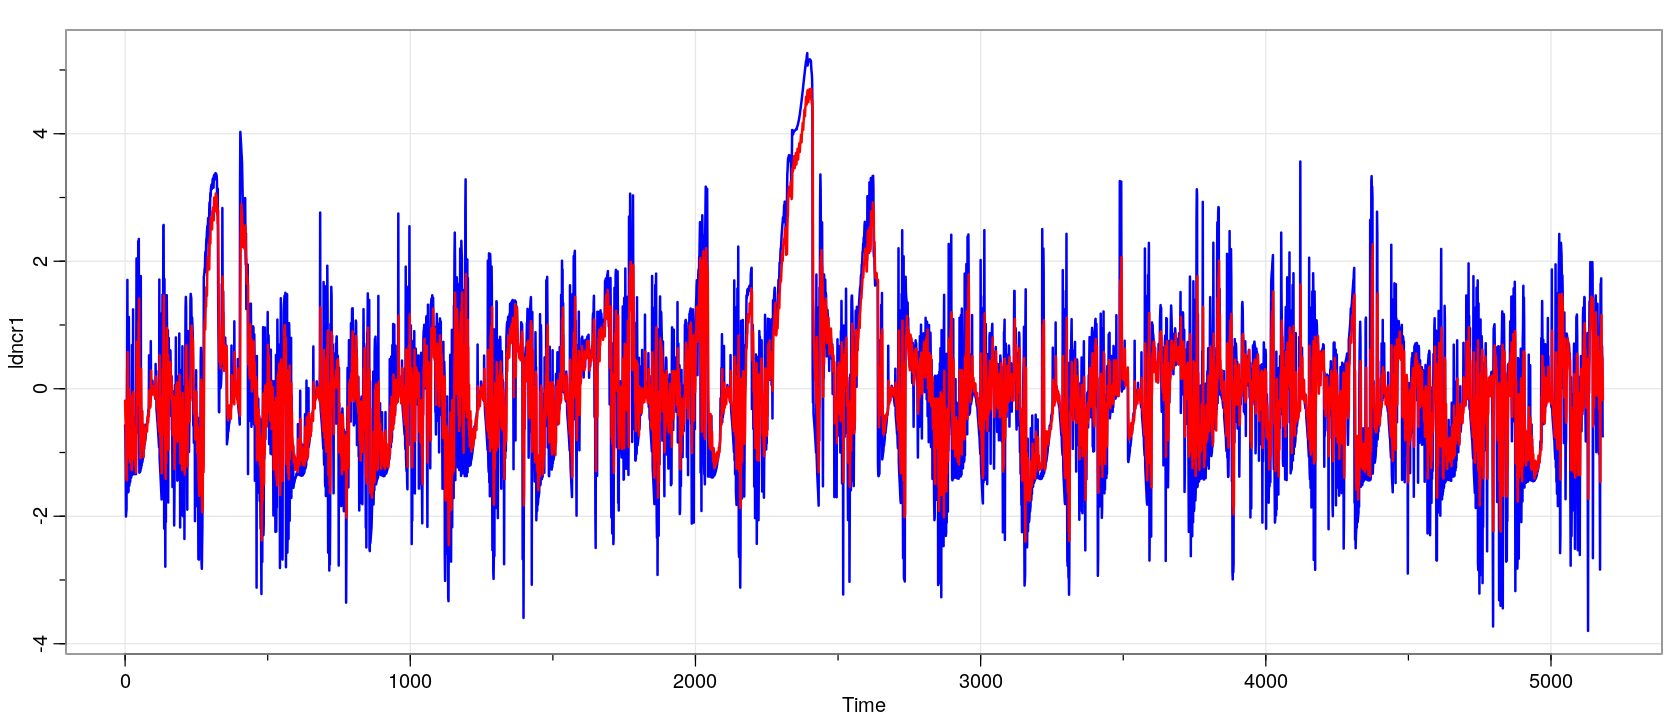

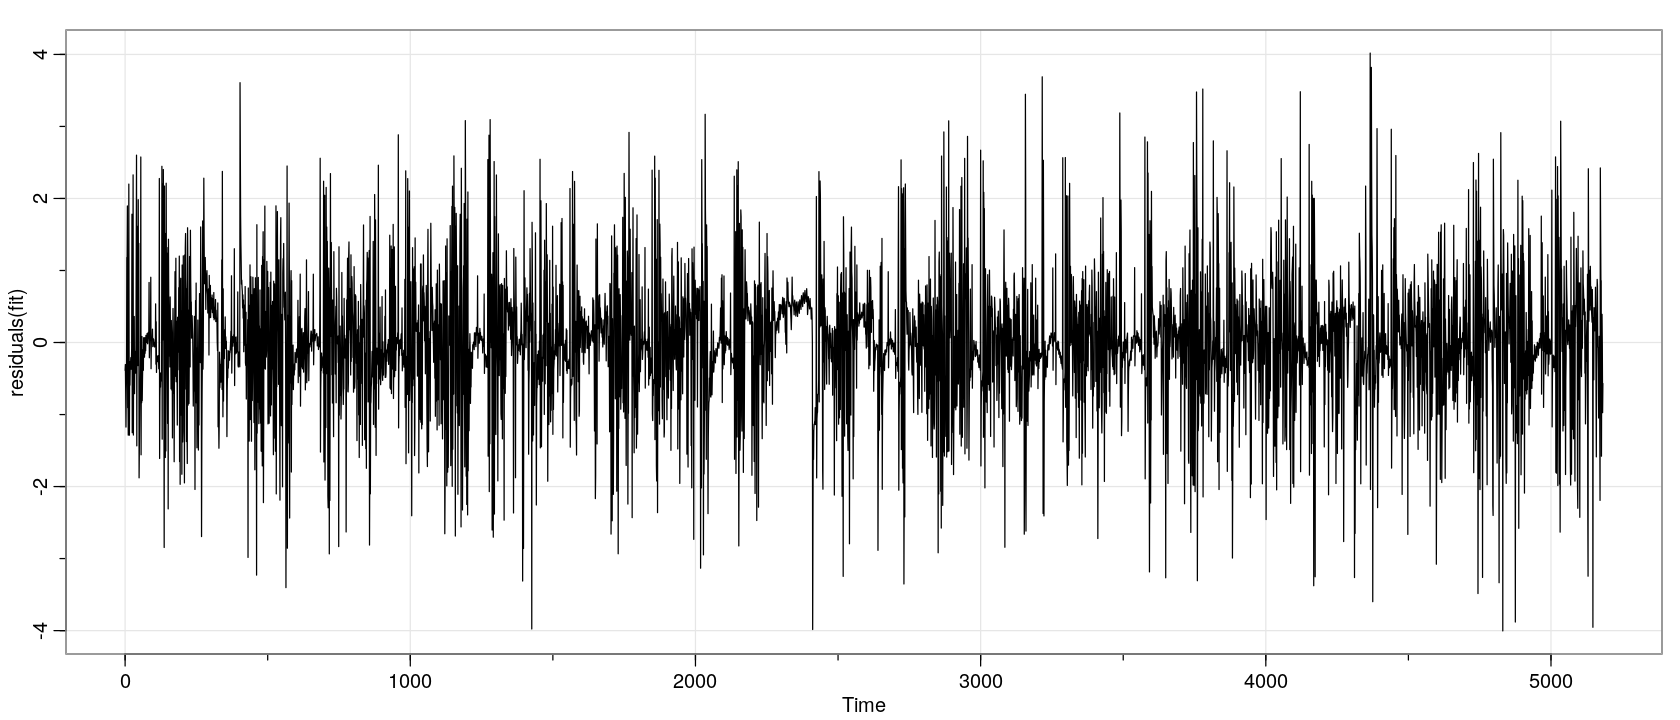

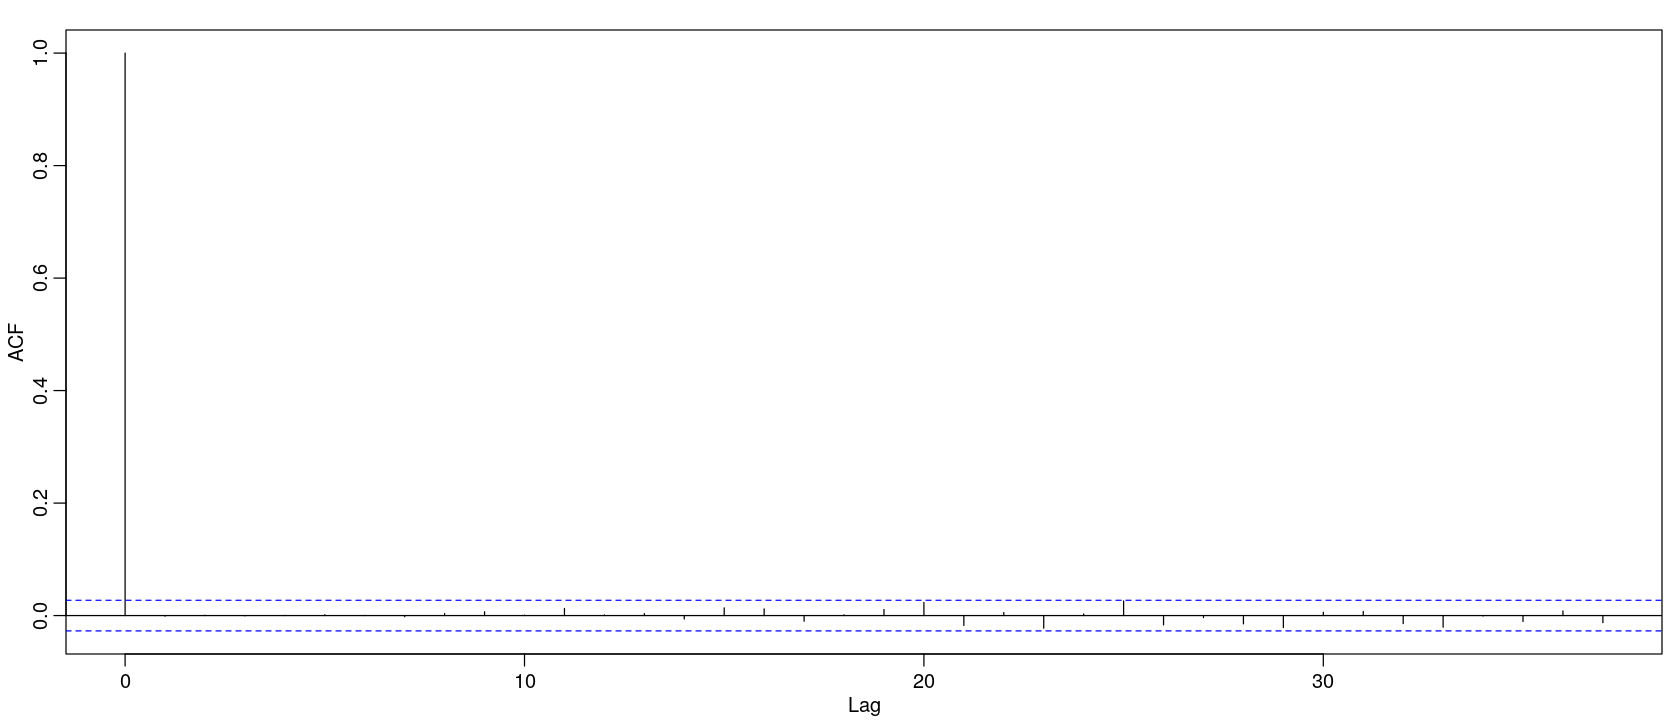

In [60]:
ldncr1 = res
        
fit = Arima(ldncr1, order = c(6,0,6), seasonal = list(order = c(6,0,1), period = 6), include.mean=FALSE)
summary(fit)
tsplot(ldncr1, col=4, lwd=2)
lines(fitted(fit), col=2, lwd=2)
tsplot(residuals(fit))
acf(residuals(fit))

#### Ajuste ARIMA(4,0,6)

En la búsqueda tambien encontramos un ARMA(4,6).
Mostramos el ajuste en la siguiente celda:

Series: ldncr1 
ARIMA(4,0,6) with zero mean 

Coefficients:
          ar1     ar2     ar3      ar4     ma1      ma2      ma3     ma4
      -0.0789  1.3758  0.2517  -0.5707  0.5377  -0.9920  -0.5779  0.2741
s.e.   0.0840  0.0710  0.0792   0.0736  0.0848   0.0934   0.0552  0.0580
         ma5      ma6
      0.0283  -0.0437
s.e.  0.0290   0.0186

sigma^2 estimated as 0.8118:  log likelihood=-6809.73
AIC=13641.46   AICc=13641.51   BIC=13713.54

Training set error measures:
                       ME      RMSE       MAE     MPE     MAPE      MASE
Training set 0.0003090887 0.9001564 0.6349852 54.2512 183.5876 0.9940652
                    ACF1
Training set 0.001090596

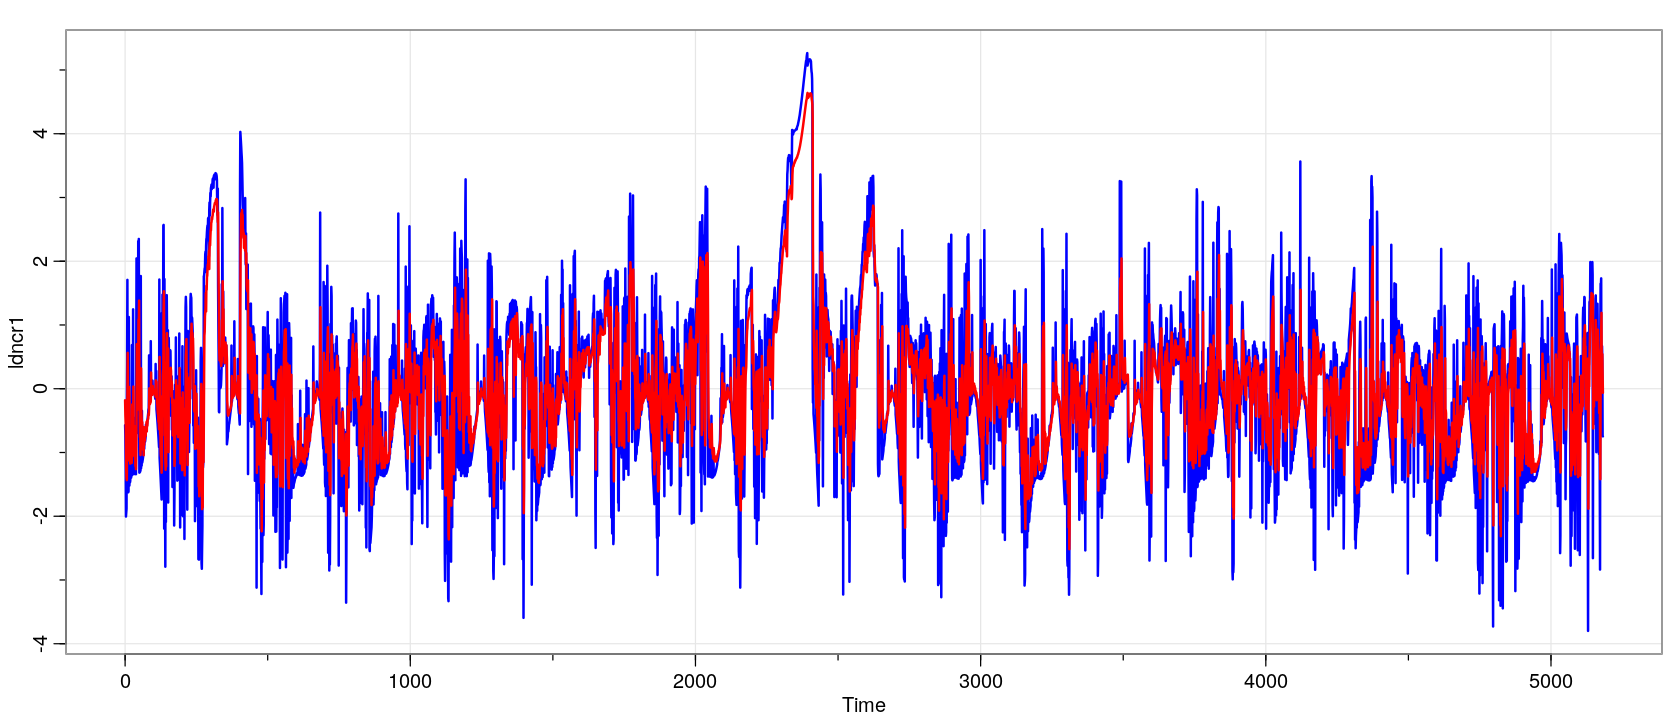

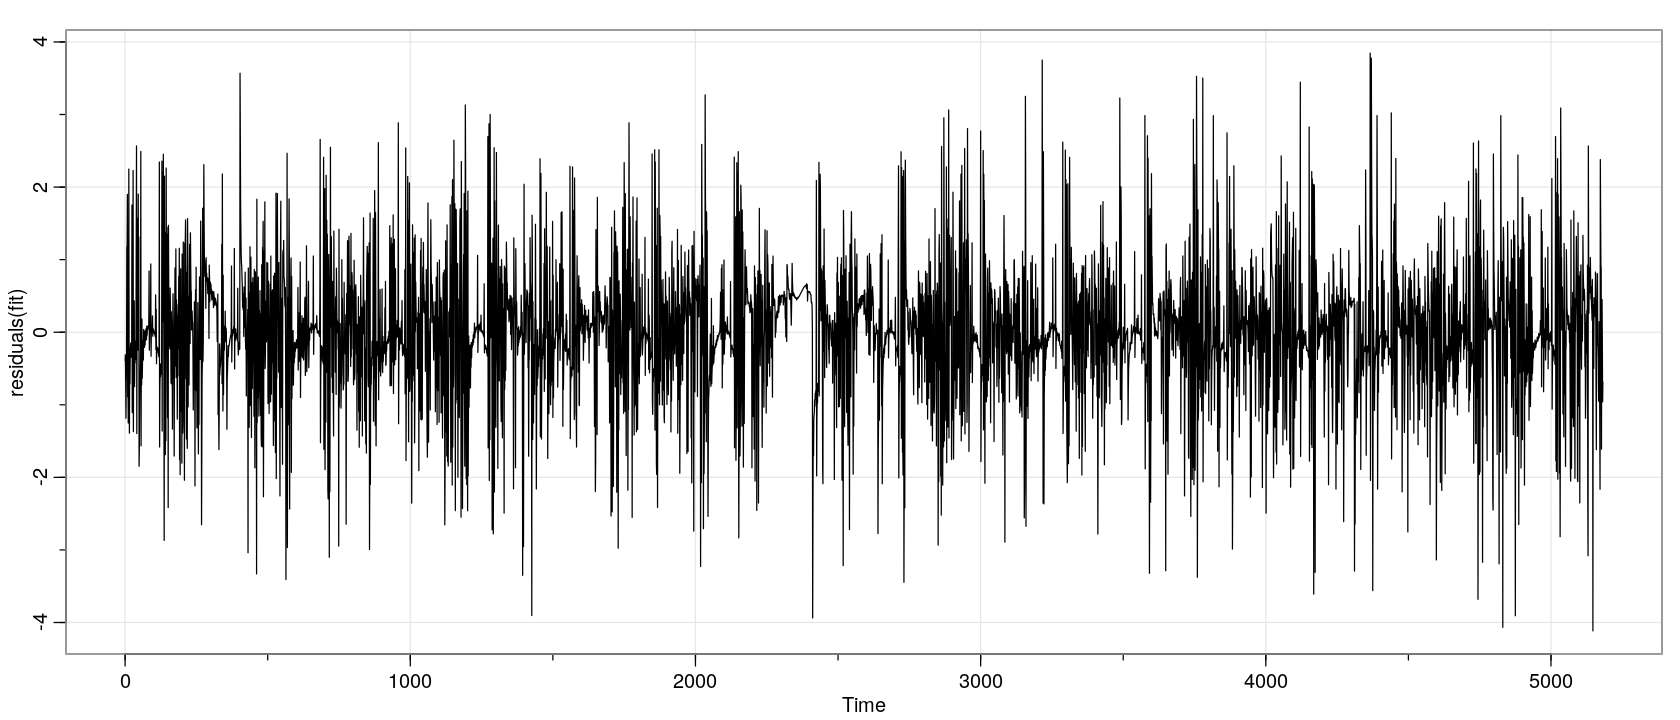

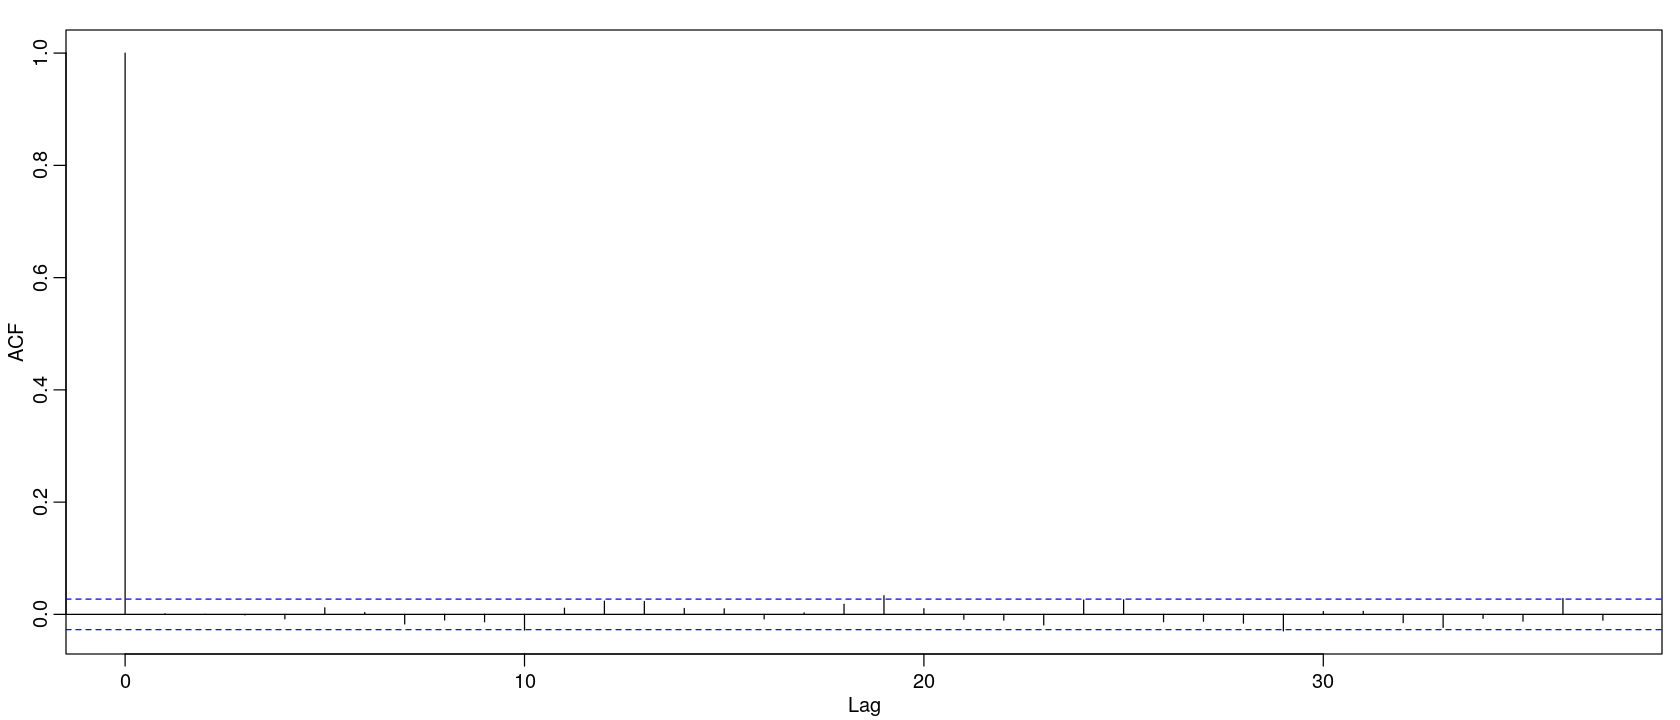

In [62]:
fit = Arima(ldncr1, order = c(4,0,6), include.mean=FALSE)
summary(fit)
tsplot(ldncr1, col=4, lwd=2)
lines(fitted(fit), col=2, lwd=2)
tsplot(residuals(fit))
acf(residuals(fit))

En estos modelos mas complejos podemos observar que los residuos son ruido blanco (todas las autocorrelaciones se ubican dentro del intervalo de confianza).

En contraposición a los modelos autorregresivos puros, encontramos que los que incluyen media móvil son mas caros en términos de procesamiento de ajustar y de obtener las predicciones. Vamos a incluir una predicción de tres días para el modelo ARMA(4,0,6).

Para la predicción con modelos con componentes de media móvil optamos por cambiar el método de ajuste a 'css', dado que el método por defecto de la función Arima ('CSS-ML') nos generó problemas con nuestra serie .


Los ajustes que obtenemos a partir de estos modelos que encontramos con la búsquedas por fuerza bruta tienen mejores AIC y sigma^2 respecto al AR(5). 
Recordar que el sigma^2 representa la varianza del ruido blanco, por lo tanto es algo que buscamos minimizar.

### Predicción próximos 3 días  (t : 5184 - 6048)

De acuerdo a los ajustes realizados en los pasos anteriores nos quedamos con tres modelos arma candidatos para probar la predicción real con los datos de test:

* AR(5) como el mejor modelo de los autorregresivos puros por cantidad de parámetros y error.
* y como resultados de la búsqueda de parámetros (minimizando AIC y buscando la mejor significancia de parámetros) : ARIMA(4,0,6) y ARIMA(6,0,6)(6,0,1)6

En el caso del modelo ARIMA(6,0,6)(6,0,1)6, el período de estacionalidad lo seteamos de acuerdo a lo que observamos en pruebas con el primer dataset (con datos de fines de semana). Allí se podían observar picos cada 6 lags; para el caso del dataset actual (sin fines de semana), dichos picos no son tan notorios pero se puede observar una leve oscilación con máximos en los mismos múltiplos de lag.

#### Función de ajuste y predicción

In [65]:
# generamos una función de ajuste y predicción 

fit_predict <- function(start_train, start_test, time_series, fit_method, p, q, seasonal_list) {
    
    ret = c(0,0)    
    ts_length = length(time_series)            
    end_train = start_test - 1

    ts_df_train = ts(time_series[start_train:end_train], start=start_train-1, frequency=1)
    ts_df_test = ts(time_series[start_test:ts_length], start=start_test-1, frequency=1)
    
    dn = ts_df_train
    dnt = ts_df_test
    
    # nuevos datos para prediccion 
    new_t = seq(start_test-1,start_test-1,by=1)
    new_t = ts(new_t,start=start_test-1,freq=1)
    new_data = data.frame(t=new_t)
    
    # agrego para probar +1 para evitar log(0)
    ldn = log(dn+1)
    ldnt = log(dnt+1)
    t = time(ldn)
    
    fit = lm(ldn ~ t, na.action=NULL)
    
    ndata <- data.frame(t = new_data)    
    predict_trend = predict(fit,newdata=ndata)
    
    predicttrend = ts(fitted(fit), start=start_train-1, freq=1)
    
    ldnc = ldn-predicttrend
    ldnc = ts(ldn-predicttrend, start=start_train-1, freq=1)
    
    t = time(ldnc)
    
    f1 =  0.003473
    f2 =  0.006946
    f3 =  0.010419

    fit = lm(ldnc ~ 0 + cos(2*pi*f1*t) + sin(2*pi*f1*t) +
                      cos(2*pi*f2*t) + sin(2*pi*f2*t) +
                     cos(2*pi*f3*t) + sin(2*pi*f3*t) ,
             na.action=NULL)
    
    prediction = ts(fitted(fit), start=start_train-1, freq=1)
    tn = start_test - 1 
    
    vdf <- data.frame(t = new_data)
    fore_f = predict(fit, vdf)    

    res = (ts(residuals(fit), start=start_train -1, freq=1))

    ldncr1 = res
        
    fit = Arima(ldncr1, order = c(p,0,q), method=fit_method, seasonal = seasonal_list, include.mean=FALSE)
    
    fore = forecast(fit, h=1)   
    
    ldnt = as.numeric(ldnt)
    ldnt = ts(ldnt, start=start_test -1, frequency=1)    
    
    v_ldnt = ldnt 
    v_pred = fore$mean + fore_f + predict_trend    
    
    v_ldnt = (exp(v_ldnt)) -1 
    v_pred = (exp(v_pred)) -1 
    
    v_ldnt[1:5]
    v_pred[1:5]
    ret = c(v_ldnt[1], v_pred[1], time(v_ldnt)[1], time(v_pred)[1])
    
    return(ret)    
}

In [74]:
# Generamos una función con la iteración para la predicción del intervalo deseado

predict_it <- function(start_test, p, q, fit_method, seasonal_list){
    sl = seasonal_list
    df_validation <- data.frame(observed=double(), predicted=double(), timeo=integer(), timep=integer())

    vect_obs <- c()
    vect_pred <- c()

    for (i in (start_test:6048)) {   
        #print(i)     
        testv <- fit_predict(i-3550, i, ts_df, fit_method, p, q, sl)
        #print(testv)
        vect_obs <- append(vect_obs, testv[1])
        vect_pred <- append(vect_pred, testv[2])
        df_validation[nrow(df_validation)+1,] = testv
    }    
    rmse_pred = rmse(vect_obs, vect_pred)
    return(list(v_obs=vect_obs,v_pred=vect_pred,rmse_pred=rmse_pred,df_validation=df_validation))    
}

### AR(5)

[1] 38.9823


    observed          predicted            timeo          timep     
 Min.   :  0.0000   Min.   : -0.0468   Min.   :5183   Min.   :5183  
 1st Qu.:  0.1488   1st Qu.:  0.8077   1st Qu.:5399   1st Qu.:5399  
 Median : 20.4743   Median : 21.4951   Median :5615   Median :5615  
 Mean   : 55.7892   Mean   : 42.8589   Mean   :5615   Mean   :5615  
 3rd Qu.: 88.6504   3rd Qu.: 59.0917   3rd Qu.:5831   3rd Qu.:5831  
 Max.   :526.9188   Max.   :408.7423   Max.   :6047   Max.   :6047  

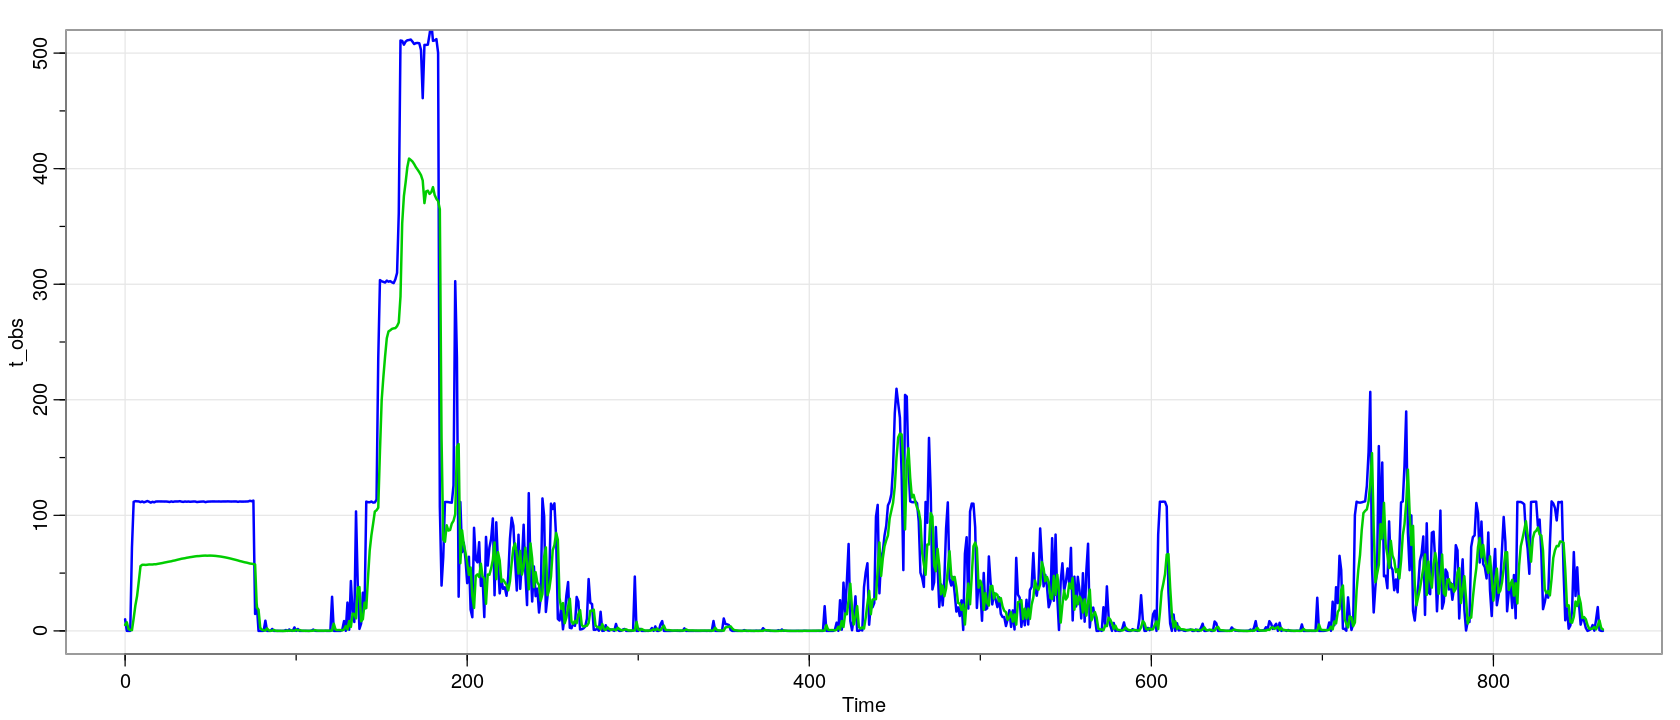

In [68]:
v_predict = predict_it(5184, 5, 0, 'CSS-ML', NaN)
print(v_predict$rmse_pred)
summary(v_predict$df_validation)

vect_obs = v_predict$v_obs
vect_pred = v_predict$v_pred

t_obs = ts(vect_obs, start=0, freq=1)
t_pred = ts(vect_pred, start=0, freq=1)

tsplot(t_obs, col=4, lwd=2, ylim=c(0,500))
lines(t_pred, col=3, lwd=2)

### ARIMA(4,0,6)

[1] 35.80442


    observed          predicted            timeo          timep     
 Min.   :  0.0000   Min.   : -0.1328   Min.   :5183   Min.   :5183  
 1st Qu.:  0.1488   1st Qu.:  0.8445   1st Qu.:5399   1st Qu.:5399  
 Median : 20.4743   Median : 21.5821   Median :5615   Median :5615  
 Mean   : 55.7892   Mean   : 44.7534   Mean   :5615   Mean   :5615  
 3rd Qu.: 88.6504   3rd Qu.: 61.8767   3rd Qu.:5831   3rd Qu.:5831  
 Max.   :526.9188   Max.   :444.7820   Max.   :6047   Max.   :6047  

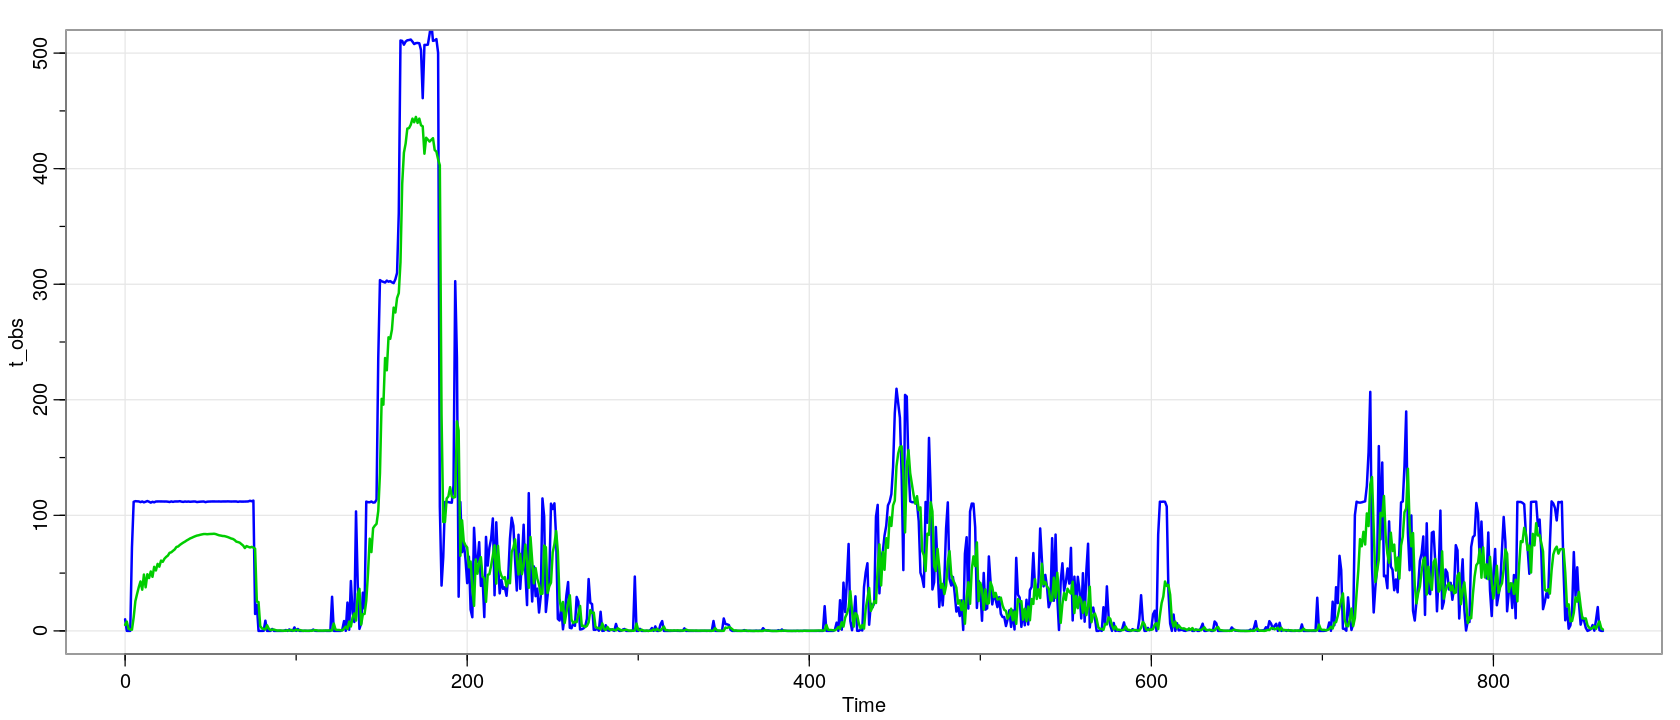

In [70]:
v_predict = predict_it(5184, 4, 6, 'CSS', NaN)

print(v_predict$rmse_pred)
summary(v_predict$df_validation)

vect_obs = v_predict$v_obs
vect_pred = v_predict$v_pred

t_obs = ts(vect_obs, start=0, freq=1)
t_pred = ts(vect_pred, start=0, freq=1)

tsplot(t_obs, col=4, lwd=2, ylim=c(0,500))
lines(t_pred, col=3, lwd=2)

### ARIMA(6,0,6)(6,0,1)6

Warning message in predict.Arima(object, n.ahead = h):
“seasonal MA part of model is not invertible”


[1] 35.67711


    observed          predicted            timeo          timep     
 Min.   :  0.0000   Min.   : -0.1758   Min.   :5183   Min.   :5183  
 1st Qu.:  0.1488   1st Qu.:  0.8322   1st Qu.:5399   1st Qu.:5399  
 Median : 20.4743   Median : 21.8720   Median :5615   Median :5615  
 Mean   : 55.7892   Mean   : 45.0183   Mean   :5615   Mean   :5615  
 3rd Qu.: 88.6504   3rd Qu.: 61.0683   3rd Qu.:5831   3rd Qu.:5831  
 Max.   :526.9188   Max.   :482.1215   Max.   :6047   Max.   :6047  

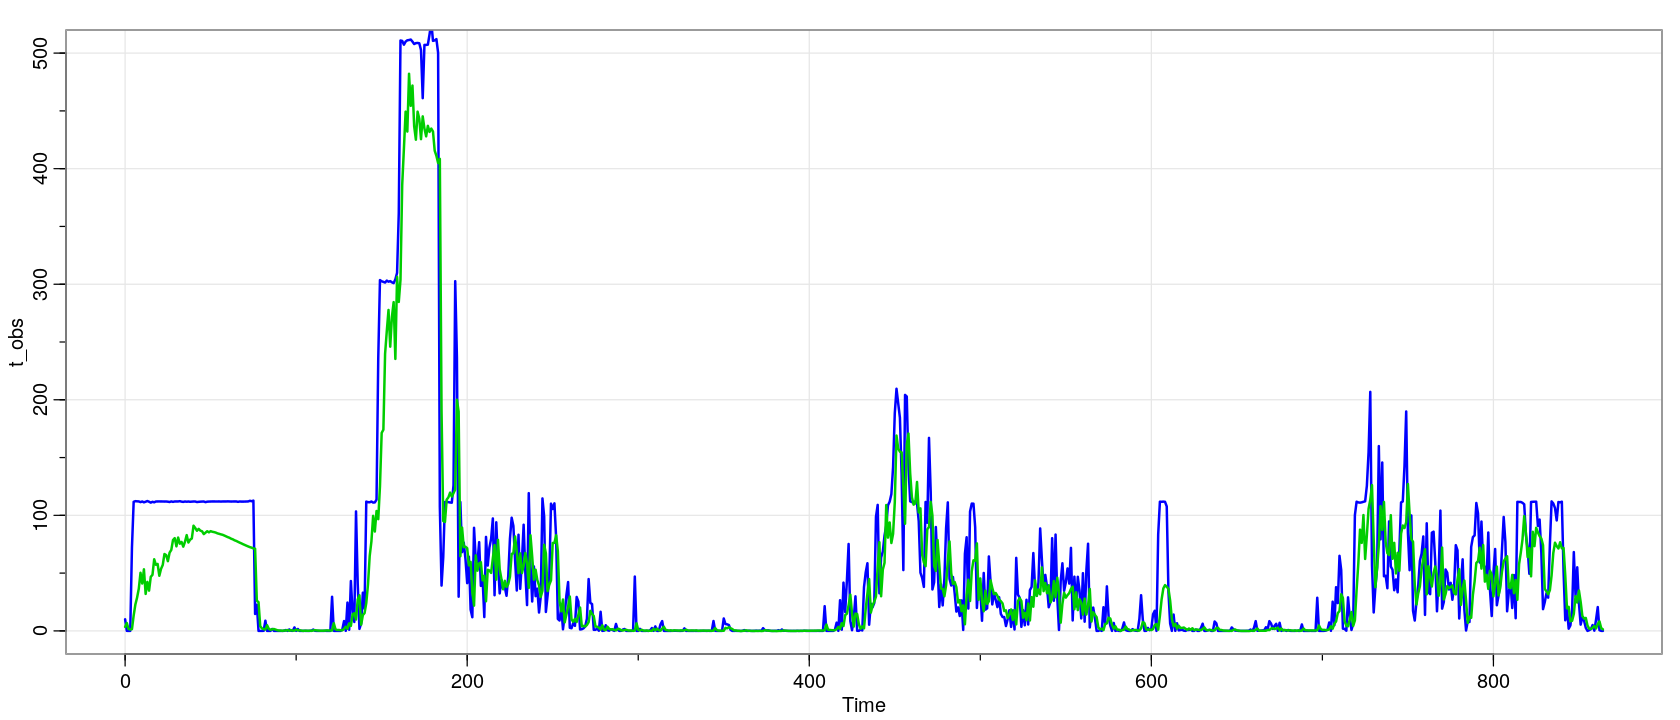

In [71]:
seasonal_list = list(order = c(6,0,1), period = 6)

v_predict = predict_it(5184,6, 6, 'CSS', seasonal_list)

print(v_predict$rmse_pred)
summary(v_predict$df_validation)

vect_obs = v_predict$v_obs
vect_pred = v_predict$v_pred

t_obs = ts(vect_obs, start=0, freq=1)
t_pred = ts(vect_pred, start=0, freq=1)

tsplot(t_obs, col=4, lwd=2, ylim=c(0,500))
lines(t_pred, col=3, lwd=2)

### Predicción próximos 2 días  (t : 5472 - 6048)

Dado que en el primer día de predicción observamos unos picos particulares respecto al resto de la serie, probamos la predicción con los últimos 2 días para observar como se desempeñan los modelos en condiciones
mas normales.

### AR(5)

[1] 26.18494


    observed           predicted             timeo          timep     
 Min.   :  0.00000   Min.   : -0.03432   Min.   :5471   Min.   :5471  
 1st Qu.:  0.05643   1st Qu.:  0.52363   1st Qu.:5615   1st Qu.:5615  
 Median :  8.81088   Median :  9.08151   Median :5759   Median :5759  
 Mean   : 31.55798   Mean   : 26.37304   Mean   :5759   Mean   :5759  
 3rd Qu.: 49.67671   3rd Qu.: 42.80881   3rd Qu.:5903   3rd Qu.:5903  
 Max.   :209.54826   Max.   :170.75039   Max.   :6047   Max.   :6047  

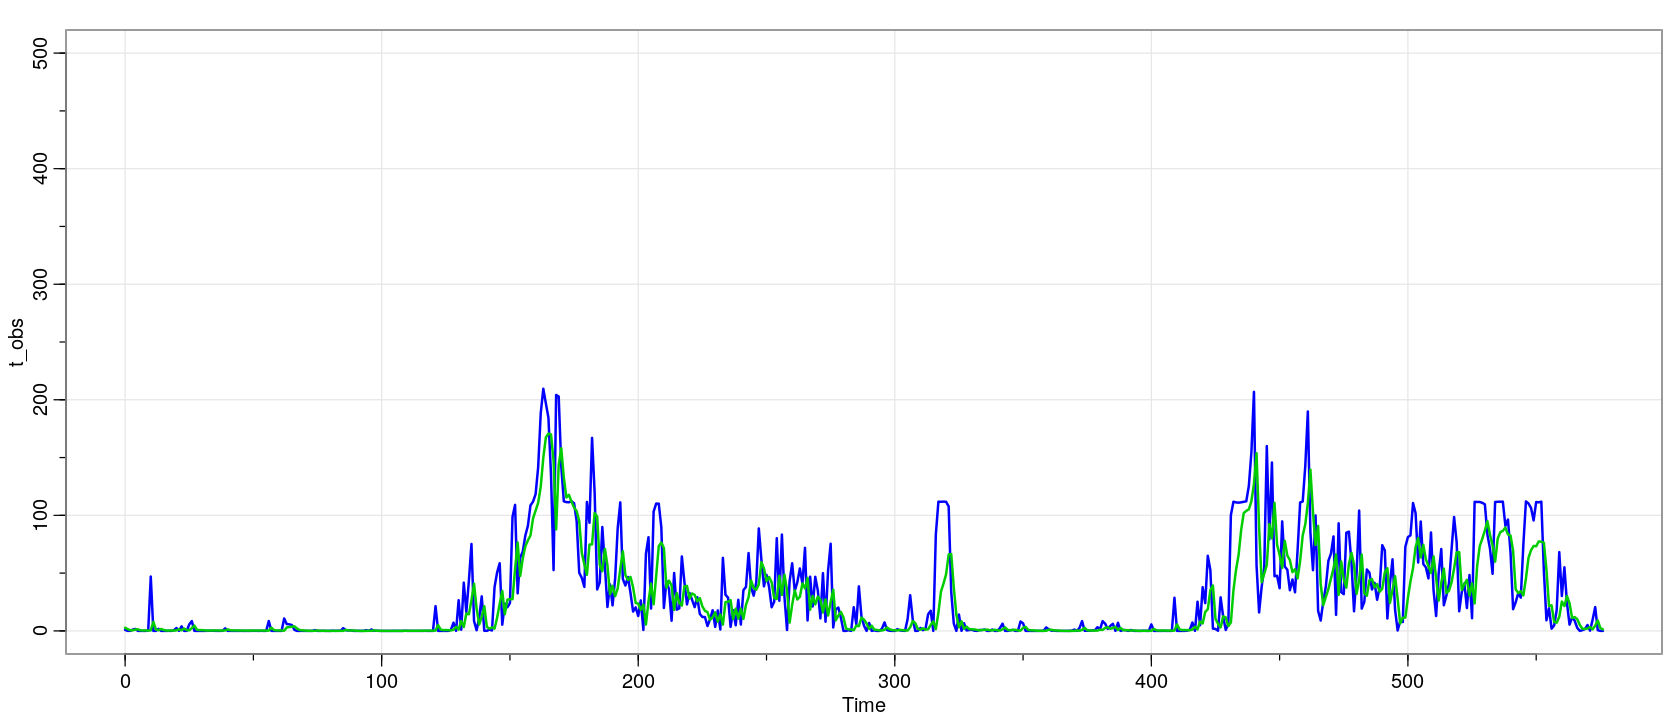

In [75]:
v_predict = predict_it(5472, 5, 0, 'CSS-ML', NaN)
print(v_predict$rmse_pred)
summary(v_predict$df_validation)

vect_obs = v_predict$v_obs
vect_pred = v_predict$v_pred

t_obs = ts(vect_obs, start=0, freq=1)
t_pred = ts(vect_pred, start=0, freq=1)

tsplot(t_obs, col=4, lwd=2, ylim=c(0,500))
lines(t_pred, col=3, lwd=2)

### ARIMA(4,0,6)

[1] 26.48748


    observed           predicted            timeo          timep     
 Min.   :  0.00000   Min.   : -0.1328   Min.   :5471   Min.   :5471  
 1st Qu.:  0.05643   1st Qu.:  0.4902   1st Qu.:5615   1st Qu.:5615  
 Median :  8.81088   Median :  8.5554   Median :5759   Median :5759  
 Mean   : 31.55798   Mean   : 25.7245   Mean   :5759   Mean   :5759  
 3rd Qu.: 49.67671   3rd Qu.: 40.6484   3rd Qu.:5903   3rd Qu.:5903  
 Max.   :209.54826   Max.   :159.7472   Max.   :6047   Max.   :6047  

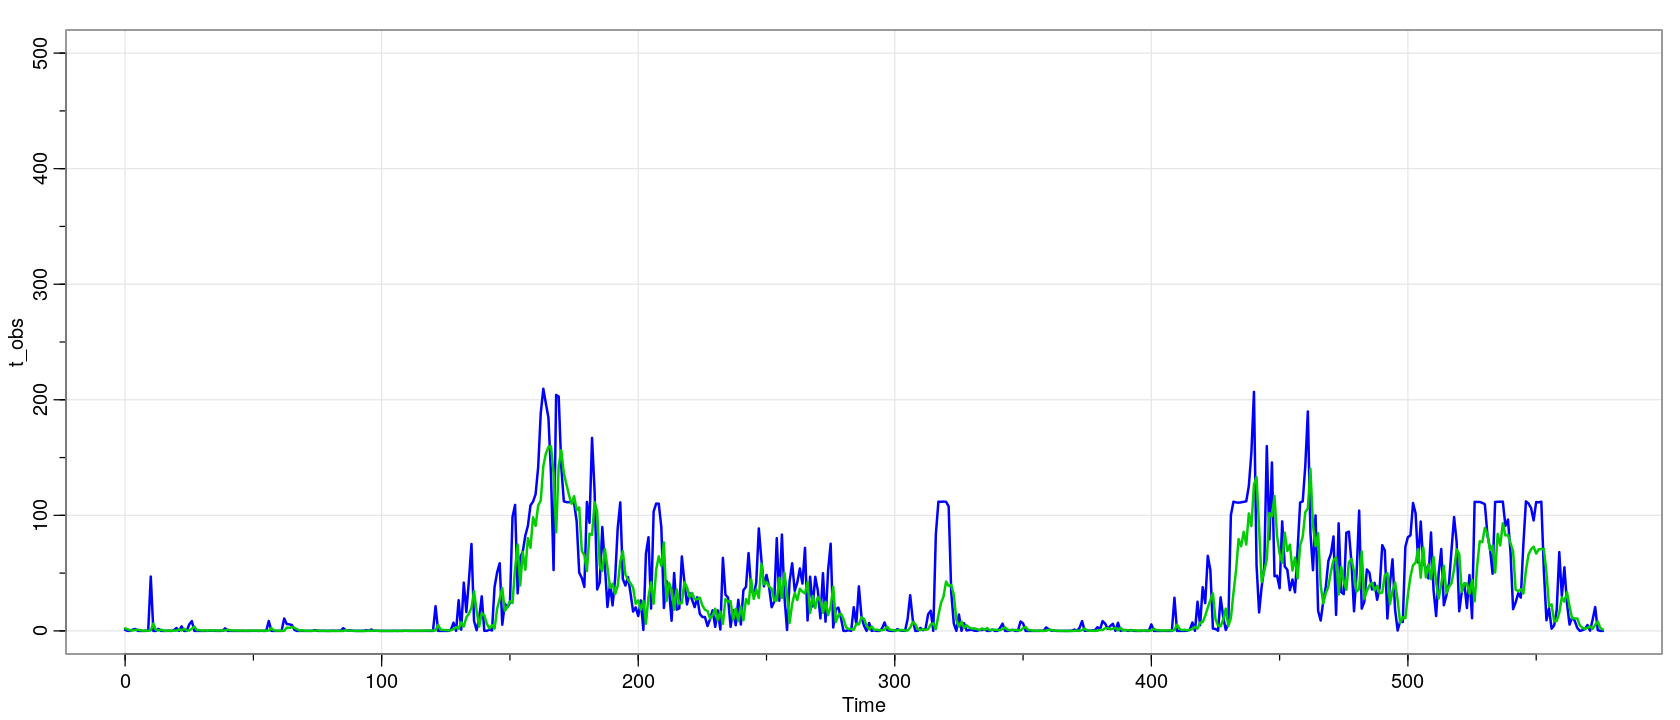

In [77]:

v_predict = predict_it(5472, 4, 6, 'CSS', NaN)

print(v_predict$rmse_pred)
summary(v_predict$df_validation)

vect_obs = v_predict$v_obs
vect_pred = v_predict$v_pred

t_obs = ts(vect_obs, start=0, freq=1)
t_pred = ts(vect_pred, start=0, freq=1)

tsplot(t_obs, col=4, lwd=2, ylim=c(0,500))
lines(t_pred, col=3, lwd=2)

### ARIMA(6,0,6)(6,0,1)6

Warning message in predict.Arima(object, n.ahead = h):
“seasonal MA part of model is not invertible”


[1] 26.0846


    observed           predicted            timeo          timep     
 Min.   :  0.00000   Min.   : -0.1758   Min.   :5471   Min.   :5471  
 1st Qu.:  0.05643   1st Qu.:  0.5147   1st Qu.:5615   1st Qu.:5615  
 Median :  8.81088   Median :  8.7641   Median :5759   Median :5759  
 Mean   : 31.55798   Mean   : 25.7898   Mean   :5759   Mean   :5759  
 3rd Qu.: 49.67671   3rd Qu.: 39.4106   3rd Qu.:5903   3rd Qu.:5903  
 Max.   :209.54826   Max.   :170.8110   Max.   :6047   Max.   :6047  

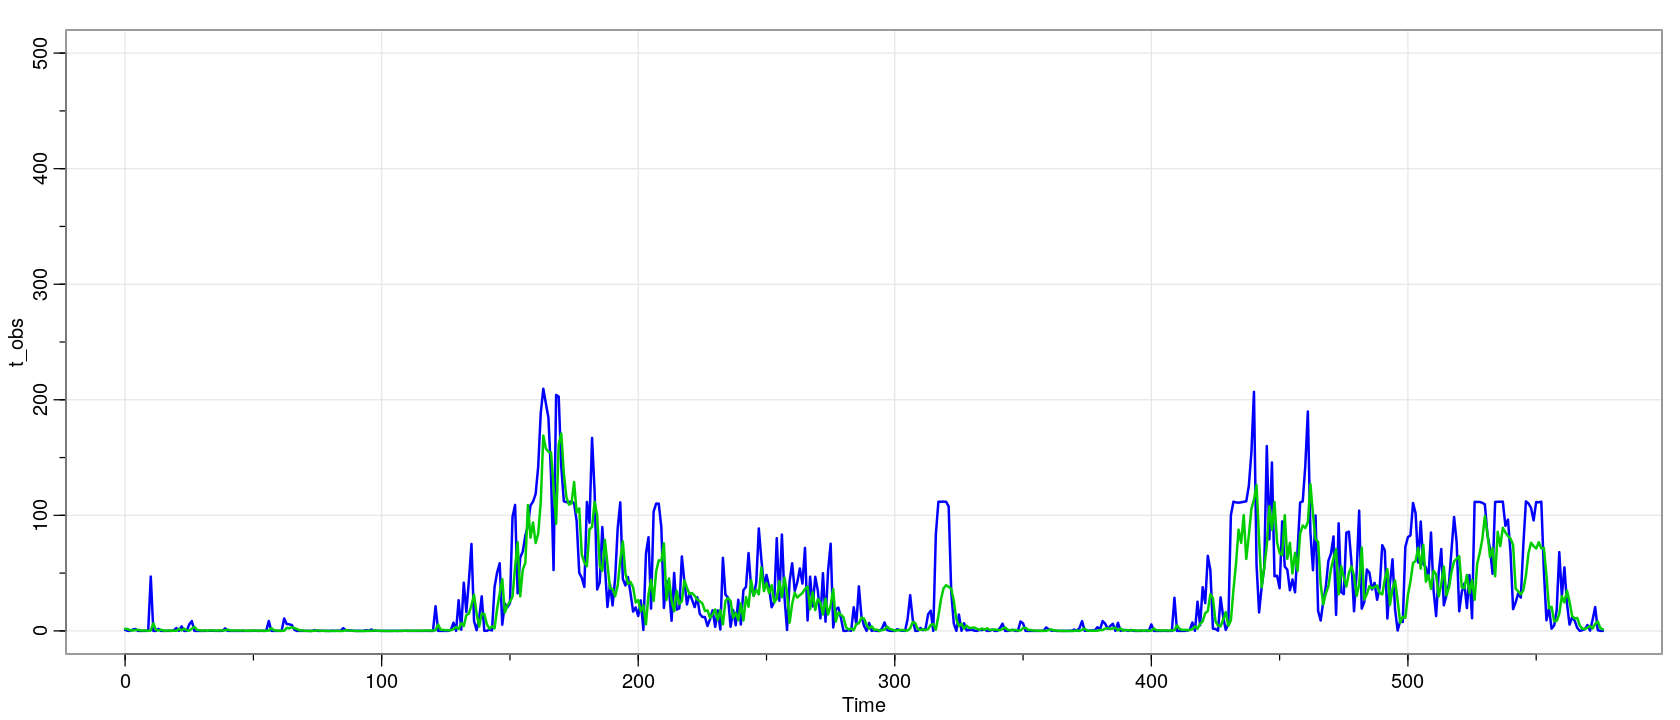

In [78]:

seasonal_list = list(order = c(6,0,1), period = 6)

v_predict = predict_it(5472,6, 6, 'CSS', seasonal_list)

print(v_predict$rmse_pred)
summary(v_predict$df_validation)

vect_obs = v_predict$v_obs
vect_pred = v_predict$v_pred

t_obs = ts(vect_obs, start=0, freq=1)
t_pred = ts(vect_pred, start=0, freq=1)

tsplot(t_obs, col=4, lwd=2, ylim=c(0,500))
lines(t_pred, col=3, lwd=2)

### Conclusión 

* Entendemos que en terminos generales llegamos a resultados relativamente satisfactorios.

* En las gráficas de predicción queda claro que a todos los modelos candidatos le cuesta capturar los picos más altos (y esto puede ser una limitante del modelo). De todas maneras todos los modelos AR logran llegar a capturarlos parcialmente y los más complejos performan un poco mejor.

* Sin embargo para lo períodos mas habituales (como se puede visualizar en los últimos dos días de predicción) la predicción es más precisa.
